# **Wikiwomen: An analysis on gender bias**
*metADAta*

We begin with taking a look at the Wikispeedia dataset and importing the files from it. The dataframe `female` is an additional dataset that we constructed ourselves.

### **Dataframes: Columns and descriptions**

| Name of dataframe | Columns                                                         | Description                                                                   |   |   |
|-------------------|-----------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| articles          | [article]                                                       | Contains the name of a wikispeedia article                                    |   |   |
| categories        | [article, category]                                             | Contains the name of a wikispeedia article and its corresponding category     |   |   |
| links             | [link_source, link_target]                                      | Contains the source and target article between links         |   |   |
| paths_finished    | [hashedIpAddress, timestamp, durationInSec, path, rating]       | Contains all finished paths                                                   |   |   |
| paths_unfinished  | [hashedIpAddress, timestamp, durationInSec, path, target, type] | Contains all unfinished paths. Type refers to the reason they were unfinished |   |   |
| shortest_distance_text  | array | Every row corresponds to a source article, in the same order as they appear in *articles*, and its value contains the shortest distance from that source article to every other article.  |   |   |
| female  | [name, womenLabel] | Contains a list of articles about females and their corresponding subcategory |   |   |

## **Importing the data**

In [1544]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from plotly.subplots import make_subplots
from IPython.display import Image

In [1545]:
DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"

In [1546]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

## **Pre-processing and dataset construction**

For our project, we are mainly interested in one category within the Wikispeedia dataset, namely the category of People, the one colored red in the following bar plot. 

In [1547]:
main_categories = pd.concat([categories, categories['category'].str.split(".", expand=True)], axis=1)
main_categories = main_categories.drop(columns = ["category", 0, 2, 3])
main_categories = main_categories.rename(columns = {"article": "name", 1: "main_category"})

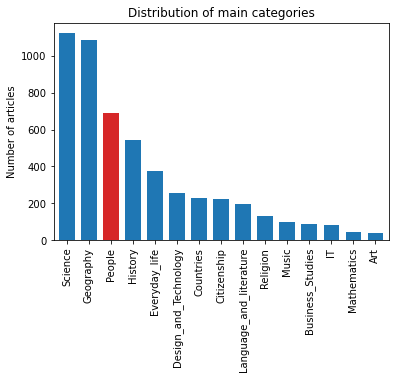

In [1548]:
# plotting the distribution of main_categories
maincategories_dist = main_categories["main_category"].value_counts()
colors = ['tab:red' if (x == "People") else 'tab:blue' for x in maincategories_dist.keys()]
maincategories_dist.plot.bar(title = "Distribution of main categories",
                             ylabel = 'Number of articles', 
                             color = colors,
                             width = 0.7)
plt.show()

We will now take a closer look of the articles and their subcategories within the People category.

In [1549]:
# finding the articles that are in the People category
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))

# constructing a new dataframe called people, only with articles from the people category
people = categories[categories["category_people"] == True]

# splitting the categories into main- and subcategories
people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns = ["category_people", "category", 0, 1])
people = people.rename(columns = {"article":"name", 2:"category"})

The number of articles about people are 689


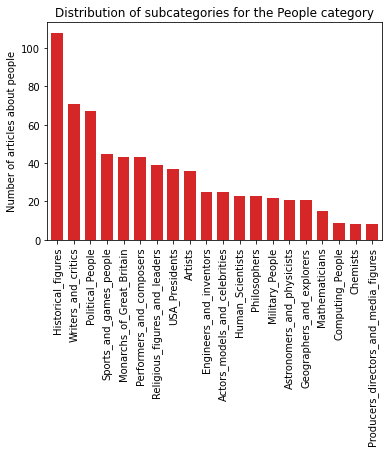

In [1550]:
print(f"The number of articles about people are {len(people)}")

# plotting the distribution of subcategories within the People category
subcategories_dist = people["category"].value_counts()
subcategories_dist.plot.bar(title = "Distribution of subcategories for the People category",
                            ylabel = 'Number of articles about people', 
                            color = "tab:red", width = 0.7)
plt.show()

For our project goals, we need to be able to identify between women and men articles. In the following cells, we will do so by using the `female` dataframe, as well as finding every node degree, i.e., every number of incoming and outcoming links from every article.

In [1551]:
# identify women and men in people
people["gender"] =  people['name'].isin(female["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")

# counting in- and out-links for every article
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()

# drop all people that have no in_link -> impossible to reach the article
people = people.merge(count_links_src, how = "left", left_on = "name", right_index = True)
people = people.merge(count_links_target, how = "inner", left_on = "name", right_index = True)
people = people.rename(columns = {"link_source": "nr_link_out", "link_target": "nr_link_in"})
people.head()

,name,category,gender,nr_link_out,nr_link_in
95,Abel_Tasman,Geographers_and_explorers,male,14,5
105,Abraham_Lincoln,USA_Presidents,male,35,62
129,Adam_Smith,Historical_figures,male,27,38
134,Adolf_Hitler,Political_People,male,78,109
159,Agamemnon,Historical_figures,male,11,9


Now that we have cleaned up the people articles, we want to take a closer look at our data. We are interested in the the distribution of female and male articles in the people-subcategories.

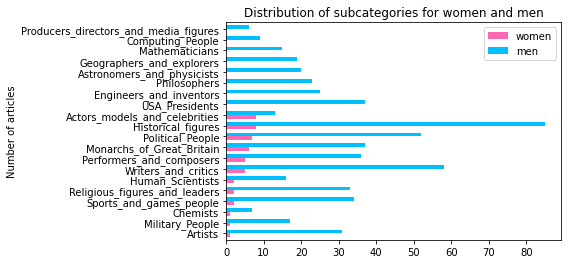

In [1552]:
women_people = people[people['gender'] == "female"]["category"].value_counts()
men_people = people[people['gender'] == "male"]["category"].value_counts()
index = men_people.keys()
men_women_cat = pd.DataFrame({'women': women_people,'men': men_people}, index=index).sort_values(by = ["women"], ascending = True)
#men_women_cat = pd.DataFrame({'women': women_people,'men': men_people}, index=index)
ax = men_women_cat.plot.barh(stacked = False, color = ['hotpink', 'deepskyblue'], 
                            title = "Distribution of subcategories for women and men",
                            ylabel = 'Number of articles', width = 0.7)
plt.show()

Now, we will construct a new dataframe called `path_overview` that contains the following columns:

| **Column_name**      | **Description**                                                     |
|----------------------|---------------------------------------------------------------------|
| source               | Source article of navigated path                                    |
| target               | Target article of navigated path                                    |
| finished             | True if path was finished, false otherwise                          |
| human_path_length    | The length of the path it took the user to go from source to target |
| shortest_path_length | Shortest possible path from a source to a target                    |
| path_deviation       | The difference between human_path_length and shortest_path_lenght   |
| playtime_sec            | Duration of game in seconds                                               |
| playtime_min           | Duration of game in minutes                                              |
| type                 | Reason for unfinished game                                          |
| failure_article      | Title of article where game was failed (unfinished)                 |
| difficulty_rating    | Difficulty rating done by players                                   |
| number_backclicks    | Number of backclicks in a path                                      |

In [1553]:
def process_path(path):
    '''
    Decompose a path and find its length. 
    Assumption: When back-clicks are encountered, we increase the path length by 1.
    :param path: a full-length path
    :return: source, target, length
    '''
    p = path.split(";")
    number_backclicks = p.count('<')
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length, number_backclicks

In [1554]:
# expand the finished paths 
path_fin = paths_finished.copy()
path_fin["source"], path_fin["target"],path_fin["human_path_length"], path_fin["number_backclicks"] = zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_fin["finished"] = True

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin["source"], path_ufin["failure_article"], path_ufin["human_path_length"], path_ufin["number_backclicks"]= zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_ufin["finished"] = False
path_ufin['target'] = paths_unfinished["target"]

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)  
path_overview = path_overview.rename(columns={"durationInSec": "playtime_sec", "rating": "difficulty_rating"})
path_overview["playtime_min"] = path_overview["playtime_sec"]/60
path_overview = path_overview[["source", "target", "finished", "human_path_length", 
                               "playtime_sec", "playtime_min", "type", "failure_article", "difficulty_rating","number_backclicks",
                               "hashedIpAddress", "timestamp"]]

**Finding the shortest path length and adding it to `path_overview`:**

We begin with creating a matrix with the shortest path length information from the imported file *shortest-path-distance-matrix.txt*:

In [1555]:
# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] 
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): 
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)

We make sure that paths with target articles that don't exist are deleted:

In [1556]:
condition = ~(path_overview['target'].isin(articles['article'].array))
path_overview = path_overview.drop(path_overview[condition].index)

Now we define a function that accesses the corresponding short distance value of a source and target pair in the matrix `shortest_distance_matrix`:

In [1557]:
def get_shortest_distance(source, target, help_articles):
    '''
    Finding the shortest path length between a source and a target
    :param source: source article 
    :param target: target article
    :param help_articles: a helper dataframe where article and index are changed
    :return: shortest_distance_matrix value for source and target article
    '''
    source_idx = help_articles.loc[source]
    target_idx = help_articles.loc[target]
    return shortest_distance_matrix[source_idx,target_idx][0]

Calling the function, we can add the shortest path length to `path_overview`:

In [1558]:
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
path_overview["shortest_path_length"] = path_overview.apply(lambda x: get_shortest_distance(x["source"], x["target"],                                                                                         help_articles), axis = 1)

Below, we remove all infeasible paths, i.e., all source and target pairs that have a shortest path length value of -1:

In [1559]:
path_overview = path_overview.drop(path_overview[path_overview['shortest_path_length'] < 0].index) 
path_overview.insert(4, 'shortest_path_length', path_overview.pop('shortest_path_length'))
path_overview.head()

,source,target,finished,human_path_length,shortest_path_length,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp
0,14th_century,African_slave_trade,True,9,3,166,2.766667,NaN,NaN,NaN,0,6a3701d319fc3754,1297740409
1,14th_century,African_slave_trade,True,5,3,88,1.466667,NaN,NaN,3.0,0,3824310e536af032,1344753412
2,14th_century,African_slave_trade,True,8,3,138,2.300000,NaN,NaN,NaN,0,415612e93584d30e,1349298640
3,14th_century,Greece,True,4,2,37,0.616667,NaN,NaN,NaN,0,64dd5cd342e3780c,1265613925
4,14th_century,John_F._Kennedy,True,7,3,175,2.916667,NaN,NaN,3.0,0,015245d773376aab,1366730828


Now, we can add the column `path_deviation` to our dataframe, which is the difference between the `human_path_length` and the `shortest_path_length`. We also remove all rows that have a negative value of path deviation, since a human path length can not be smaller than the shortest path length.

In [1560]:
# add path_deviation to path_overview
path_overview["path_deviation"] = path_overview["human_path_length"] - path_overview["shortest_path_length"]

# we remove all rows that have a negative path_dev
path_overview = path_overview.drop(path_overview.index[path_overview['path_deviation'] < 0])
path_overview.insert(5, 'path_deviation', path_overview.pop('path_deviation'))
path_overview.head()

,source,target,finished,human_path_length,shortest_path_length,path_deviation,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp
0,14th_century,African_slave_trade,True,9,3,6,166,2.766667,NaN,NaN,NaN,0,6a3701d319fc3754,1297740409
1,14th_century,African_slave_trade,True,5,3,2,88,1.466667,NaN,NaN,3.0,0,3824310e536af032,1344753412
2,14th_century,African_slave_trade,True,8,3,5,138,2.300000,NaN,NaN,NaN,0,415612e93584d30e,1349298640
3,14th_century,Greece,True,4,2,2,37,0.616667,NaN,NaN,NaN,0,64dd5cd342e3780c,1265613925
4,14th_century,John_F._Kennedy,True,7,3,4,175,2.916667,NaN,NaN,3.0,0,015245d773376aab,1366730828


In [1561]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")

Let's turn our attention to all people, and identify the paths in `path_overview` that only have people as target article:

In [1562]:
# find only targets that are people
people_target_paths = path_overview.merge(people[['name', 'category', 'gender', 'nr_link_in']], 
                                          how = "inner", left_on = "target", right_on = "name")

To prepare for our work with the in-degree, we define a column `in_degree_rep` in `people_target_paths`. Since we have 77 unique in-degree values, we decide to create 10 equally sized groups and map the in-degree values to these 10 groups.

In [1563]:
people_target_paths["in_degree_rep"] = pd.cut(people_target_paths["nr_link_in"], bins=10, labels=np.arange(1,11,1))

We can now find all paths that have women-targets and all paths that have men-targets:

In [1564]:
# find only targets that are women
women_target_paths = people_target_paths[people_target_paths['gender'] == "female"]
print(f"The number of paths that have women as a target article is {len(women_target_paths)}")

The number of paths that have women as a target article is 560


In [1565]:
# find only targets that are men
men_target_paths = people_target_paths[people_target_paths['gender'] == "male"]
print(f"The number of paths that have men as a target article is {len(men_target_paths)}")

The number of paths that have men as a target article is 7187


**A closer look of men vs. women articles**

In [1566]:
women = len(people_target_paths[people_target_paths['gender'] == "female"])
men = len(people_target_paths[people_target_paths['gender'] == "male"])
women_finished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == True)])
men_finished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == True)])
women_unfinished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == False)])
men_unfinished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == False)])

print(f"Number of paths with a woman as a target {women} ({(women/(women+men))*100:.2f} % (of paths with a target related to a person))")
print(f"Number of paths with a man as a target {men} ({(men/(women+men))*100:.2f} %)")
print()
print(f"Number of finished paths with a woman as a target {women_finished} ({(women_finished/(women_finished+men_finished))*100:.2f}%)")
print(f"Number of finished paths with a man as a target {men_finished} ({(men_finished/(women_finished+men_finished))*100:.2f}%)")
print()
print(f"Number of unfinished paths with a woman as a target {women_unfinished} ({(women_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")
print(f"Number of unfinished paths with a man as a target {men_unfinished} ({(men_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")

Number of paths with a woman as a target 560 (7.23 % (of paths with a target related to a person))
Number of paths with a man as a target 7187 (92.77 %)

Number of finished paths with a woman as a target 347 (5.71%)
Number of finished paths with a man as a target 5727 (94.29%)

Number of unfinished paths with a woman as a target 213 (12.73%)
Number of unfinished paths with a man as a target 1460 (87.27%)


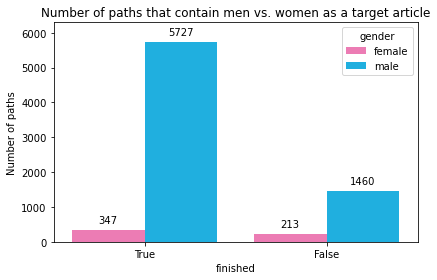

In [1567]:
ax = sns.countplot( data=people_target_paths, x = "finished", hue="gender", 
                    order = [True,False], hue_order=["female","male"], palette = ['hotpink','deepskyblue'])
 
ax.set_title('Number of paths that contain men vs. women as a target article')
ax.set_ylabel("Number of paths")
ax.margins(y=0.1) # make room for the labels
for bars in ax.containers:
    ax.bar_label(bars, padding = 5)
plt.tight_layout()
plt.show()

To compute the success rate of finishing a path with a certain target article, we will count how many times a game with a certain target article was finished, and divide it with the total number of paths where it was the target:

In [1568]:
# count total, finished and unfinished number of times a target article was reached
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")

# add this information to the people dataframe
people = people.merge(tot_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(unf_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(fin_target, how = "left",  left_on = "name", right_index = True)

In [1569]:
# compute success rate of finishing a path
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']

In [1570]:
people.to_csv("./data/people_overview.csv")

In [1571]:
people

,name,category,gender,nr_link_out,nr_link_in,tot_target_count,unf_target_count,fin_target_count,succ_rate
95,Abel_Tasman,Geographers_and_explorers,male,14,5,8.0,1.0,7.0,0.875000
105,Abraham_Lincoln,USA_Presidents,male,35,62,36.0,1.0,35.0,0.972222
129,Adam_Smith,Historical_figures,male,27,38,10.0,1.0,9.0,0.900000
134,Adolf_Hitler,Political_People,male,78,109,644.0,41.0,603.0,0.936335
159,Agamemnon,Historical_figures,male,11,9,23.0,4.0,19.0,0.826087
...,...,...,...,...,...,...,...,...,...
5188,Zhang_Qian,Historical_figures,male,19,3,1.0,1.0,NaN,NaN
5190,Zheng_He,Historical_figures,male,39,8,7.0,2.0,5.0,0.714286
5191,Ziad_Jarrah,Historical_figures,male,25,1,11.0,6.0,5.0,0.454545
5197,Zionism,Political_People,male,74,25,12.0,2.0,10.0,0.833333


## **Statistical analysis**

### **Naive analysis** 

The first step of our data analysis will be a naive statistical analysis, where we will check for differences in the following metrics:

- **success_rate**
- **in_degree**
- **playtime**
- **path_deviation**
- **number_backclicks** 
- **difficulty_rating**

These differences will be checked for significance using bootstrap confidence intervals.

To do so, we define a function `bootstrap_metric` that returns the estimated arithmetic mean, geometric mean of a metric and finds the confidence interval of the estimated value. 

In [1572]:
def bootstrap_metric(metric, dataframe:pd.DataFrame, gender, summary:pd.DataFrame = pd.DataFrame(), 
                     estimator = "Geometric", remove_zero = True, ci = 0.9):
    '''
    Find the estimated mean (arithmetic or geometric) or median of a metric and the ci*100% CI.
    :param metric: metric to be estimated
    :param dataframe: from which dataframe the metric comes from
    :param gender: gender of article, "male" or "female"
    :param summary:pd.DataFrame = pd.DataFrame(): a summary dataframe
    :param estimator: default value is Geometric, but one can also find the Arithmetic mean or the Median
    :param remove_zero: default value is True, so all zero values of the metric are removed from the dataframe
    :param ci: default value is 0.90, so the 90% CI of the estimate would be found
    :return: the estimated mean and the ci*100% CI
    '''
    if remove_zero:
        # Since the geometric mean is only defined for strictly positive data points we enable the option to remove the zeros. 
        dataframe = dataframe[dataframe[metric] > 0]
        data = dataframe[dataframe["gender"]== gender][metric]
    else:
        data = dataframe[dataframe["gender"]== gender][metric]
    
    data_bootstrap = (data.dropna().to_numpy(),)
    
    if estimator =="Geometric":
        geom_mean = stats.gmean(data.dropna().to_numpy(), dtype=None)
        print(f"{gender}: Geometric mean: {geom_mean}")
    
        # estimating the ci% CI of the geometric mean of the metric
        res_bootstrap_gm = stats.bootstrap(data_bootstrap, stats.gmean, confidence_level=ci)
        print(f"{gender}: {ci*100}% confidence interval of the geometric mean of {metric}: [{res_bootstrap_gm.confidence_interval[0]:.3f}, "
          f"{res_bootstrap_gm.confidence_interval[1]:.3f}]")

        # add information to summary if dataframe is supplied
        if not summary.columns.empty:
          new_row = pd.Series({'gender': gender, "gmean": geom_mean, "ci_0": res_bootstrap_gm.confidence_interval[0],
                                    'ci_1': res_bootstrap_gm.confidence_interval[1], "metric": metric})
          summary = pd.concat([summary, new_row.to_frame().T], ignore_index=True)
        
        return geom_mean, summary

    elif estimator == "Arithmetic":
        arith_mean = data.mean()
        print(f"{gender}: Arithmetic mean: {arith_mean}")
    
        # estimating the ci% CI of the arithmetic mean of the metric
        res_bootstrap_am = stats.bootstrap(data_bootstrap, np.mean, confidence_level=ci)
        print(f"{gender}: {ci*100}% confidence interval of the arithmetic mean of {metric}: [{res_bootstrap_am.confidence_interval[0]:.3f}, "
          f"{res_bootstrap_am.confidence_interval[1]:.3f}]")
        return arith_mean, summary

Next we define a helper function that plots two histograms on the same plot:

In [1573]:
def plot_2_dist(column, dataframe, bins = np.array([]), my_title = "", my_xlabel = "", my_ylabel = "", xlog=False, ylog=False):
    '''
    Plot two histograms with a vertical line that describes the median of the metric.
    :param column: metric to be plotted
    :param dataframe: from which dataframe the metric comes from
    :param bins: number of bins
    :param my_title: set the title of the plot
    :param my_xlabel: set the x label of the plot
    :param my_ylabel: set the y label of the plot
    :param xlog: set to True if you wish to plot the histogram with a log-scale on x-axis
    :param ylog: set to True if you wish to plot the histogram with a log-scale on y-axis
    :return: plot
    '''
    female = dataframe[dataframe["gender"]== "female"][column]
    male = dataframe[dataframe["gender"]== "male"][column]
    
    
    if bins.size == 0:
        bins = np.arange(min(female)-0.5, max(female) + 0.5, 1)
    # plot the male distribution of the metric
    plt.hist(male, 
            color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.5,
            bins= bins, label ="male")
    # plot the female distribution of the metric
    plt.hist(female, 
            color = 'tab:red', edgecolor = 'black', linewidth = 0.5, alpha=0.5, 
            bins= bins, label ="female")
    plt.xlabel(my_xlabel)
    plt.ylabel(my_ylabel)
    if ylog:
        plt.yscale('log')
    if xlog:
        plt.xscale('log')
    plt.title(my_title)
    # add a vertical line that describes the geometric mean of the metric

    
    plt.axvline(stats.gmean(female),color="tab:red", label= "gmean female")
    plt.axvline(stats.gmean(male), color="tab:blue", label= "gmean male")

    plt.legend()
    plt.show()

Defining a function that can create the summary figure. This figure represents the findings of comparing the geometric means of the different metrics. We use a logaritmic scale in order to represent all the metrics in one plot. Since we are only interested in seeing if the difference is significant and not on the size of the confidence interval, we accept the fact that the sizes are not directly comparable. 

In [1574]:
def summary_figure(summary:pd.DataFrame, nr_datapoints:str, matched_on:str, filename:str, opacity = [1,1,1,1,1]):
    '''
    Plot the summary figure, depending on the summary dataframe, and filling out the labels accordingly
    :params summary:pd.DataFrame: data to be displayed
    :params nr_datapoints: how many datapoints were used to compute the metrics
    :params matched_on: complete the title
    :params filename: set the filename, for the folder datastory_plot
    :params: opacity: define which metrics are significant, significant should be one, insignificant 0.4
    '''


    summary["gmean"]= summary["gmean"].apply(lambda x: np.round(x,3))
    summary["ci_0"]= summary["ci_0"].apply(lambda x: np.round(x,3))
    summary["ci_1"]= summary["ci_1"].apply(lambda x: np.round(x,3))
    summary["plus_error"] = summary["ci_1"] - summary["gmean"]
    summary["minus_error"] = summary["gmean"]- summary["ci_0"]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        name='female',
        x=summary[summary["gender"] =="female"]["metric"],
        y=summary[summary["gender"] =="female"]["gmean"],
        error_y=dict(type='data', 
                    array=summary[summary["gender"] =="female"]["plus_error"],
                    arrayminus=summary[summary["gender"] =="female"]["minus_error"]
                    ),
        marker=dict(color=["hotpink", "hotpink", "hotpink", "hotpink", "hotpink", "hotpink"],opacity=opacity)  
        
    ))
    fig.add_trace(go.Bar(
        name='male',
        x=summary[summary["gender"] =="male"]["metric"],
        y=summary[summary["gender"] =="male"]["gmean"],
        error_y=dict(type='data',
                    array=summary[summary["gender"] =="male"]["plus_error"],
                    arrayminus=summary[summary["gender"] =="male"]["minus_error"]),
        marker=dict(color=["skyblue", "skyblue", "skyblue", "skyblue", "skyblue", "skyblue"],opacity=opacity)  
    ))

    fig.update_traces(hovertemplate='Geometric mean: %{y}')

    
    fig.update_layout(title=go.layout.Title(
                        text=f"Comparison of the geometric mean for articles matched on {matched_on}<br><sup>Error bars: CI (90%), number of matched articles: {nr_datapoints}</sup>",
                        xref="paper",
                        x=0),
                        barmode='group', 
                        template = "simple_white",
                        xaxis_title="Metrics",
                        yaxis_title="Geometric mean (log-scale)",
                        legend_title = "Gender",
                        font=dict(
                            family="Times New Roman, serif",
                            color="#404040"
                        ))
    fig.update_yaxes(type="log")

    fig.show()
    # fig.write_html(f"datastory_plot/{filename}.html", full_html=False, include_plotlyjs='cdn')

#### **Success rate**

For each of the following analyses we follow the same procedure, going through all the metrics and comparing the geometric mean and the confidence interval. On the basis of the confidence intervals, we then decide whether the difference in mean between women and men can be considered significant.

In [1575]:
naive_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])
wsuccessrate_mean, naive_summary = bootstrap_metric("succ_rate", people, "female", estimator = 'Geometric', remove_zero=True, ci = 0.9, summary= naive_summary)
msuccessrate_mean, naive_summary = bootstrap_metric("succ_rate", people, "male", estimator = 'Geometric', remove_zero=True, ci = 0.9, summary= naive_summary)

female: Geometric mean: 0.6068480390130131
female: 90.0% confidence interval of the geometric mean of succ_rate: [0.502, 0.686]
male: Geometric mean: 0.7758441073276038
male: 90.0% confidence interval of the geometric mean of succ_rate: [0.748, 0.798]


The fact that the two confidence intervals do not overlap implies that there is a significant difference in the success rate of these two groups.

For a more intuitive feeling we also always take a look at the distribution of the the two groups. 

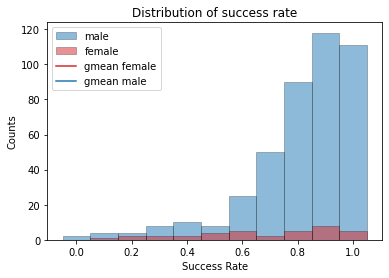

In [1576]:
plot_2_dist("succ_rate", people, bins= np.arange(0-0.05,1+0.15,0.1),my_title="Distribution of success rate", my_xlabel="Success Rate", my_ylabel="Counts")

#### **Playtime**

After the success rate, we look at the playtime in minutes. Since a time is only valid as a playtime if the path was finished, we are looking at a a filtered dataset, with only finished paths. 

**Playtime of finished articles**

In [1577]:
wplaytimemin_mean, naive_summary = bootstrap_metric("playtime_min", people_target_paths[people_target_paths["finished"] == True], "female", 
                                  estimator = 'Geometric', ci = 0.9, summary= naive_summary)
mplaytimemin_mean, naive_summary = bootstrap_metric("playtime_min", people_target_paths[people_target_paths["finished"] == True], "male", 
                                  estimator = 'Geometric', ci = 0.9, summary= naive_summary)

female: Geometric mean: 2.384064549174565
female: 90.0% confidence interval of the geometric mean of playtime_min: [2.212, 2.569]
male: Geometric mean: 1.686718392076239
male: 90.0% confidence interval of the geometric mean of playtime_min: [1.655, 1.717]


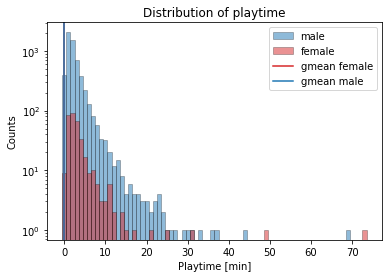

In [1578]:
plot_2_dist("playtime_min", people_target_paths[people_target_paths["finished"] == True], 
            my_title="Distribution of playtime", my_xlabel="Playtime [min]", my_ylabel="Counts", ylog=True, xlog=False)

#### **Path deviation**

The next step concerns the path deviation. As explained earlier it is the difference between the shortest possible path and the human path. We have decided to only use this metric on finished paths. 

**Path deviation of finished articles**

In [1579]:
wpathdev_mean, naive_summary = bootstrap_metric("path_deviation", people_target_paths[people_target_paths["finished"] == True], 
                                 "female", estimator = 'Geometric', remove_zero = False, ci = 0.9, summary= naive_summary)

mpathdev_mean, naive_summary = bootstrap_metric("path_deviation", people_target_paths[people_target_paths["finished"] == True], 
                                 "male", estimator = 'Geometric', remove_zero = False, ci = 0.9, summary= naive_summary)

female: Geometric mean: 3.1422912007889443
female: 90.0% confidence interval of the geometric mean of path_deviation: [2.926, 3.377]
male: Geometric mean: 2.6369112781430974
male: 90.0% confidence interval of the geometric mean of path_deviation: [2.597, 2.678]


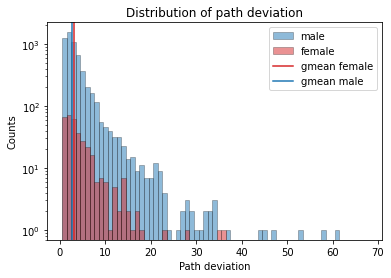

In [1580]:
plot_2_dist("path_deviation", people_target_paths[people_target_paths["finished"] == True], 
            my_title="Distribution of path deviation", my_xlabel="Path deviation", my_ylabel="Counts", ylog=True)

#### **In-degree**

The in-degree shows topology-related bias. If there is a significant difference between the two, it is harder to reach a female target article then a male one. 

In [1581]:
wlink_in, naive_summary = bootstrap_metric("nr_link_in", people, "female", estimator = 'Geometric', ci = 0.9, summary= naive_summary)
mlink_in, naive_summary = bootstrap_metric("nr_link_in", people, "male", estimator = 'Geometric', ci = 0.9, summary= naive_summary)

female: Geometric mean: 6.23063003703265
female: 90.0% confidence interval of the geometric mean of nr_link_in: [4.731, 8.245]
male: Geometric mean: 9.601510226110804
male: 90.0% confidence interval of the geometric mean of nr_link_in: [8.903, 10.365]


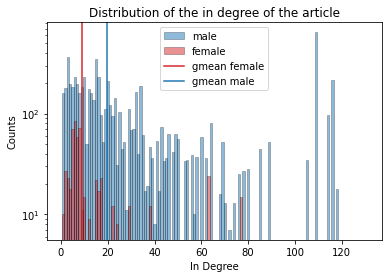

In [1582]:
plot_2_dist("nr_link_in", people_target_paths,
            my_title="Distribution of the in degree of the article", my_xlabel="In Degree", my_ylabel="Counts", ylog=True)

#### **Number of back clicks**

By looking at this metric, we want to check whether the players have to go back more often on their way to a female article. The number of back clicks takes a closer look at long paths. 

In [1583]:
wback_mean, naive_summary = bootstrap_metric("number_backclicks", people_target_paths, "female", estimator = 'Geometric', ci = 0.9, summary= naive_summary)
mback_mean, naive_summary = bootstrap_metric("number_backclicks", people_target_paths, "male", estimator = 'Geometric', ci = 0.9, summary= naive_summary)

female: Geometric mean: 1.7940964206248158
female: 90.0% confidence interval of the geometric mean of number_backclicks: [1.644, 1.973]
male: Geometric mean: 1.7091503765956244
male: 90.0% confidence interval of the geometric mean of number_backclicks: [1.655, 1.768]


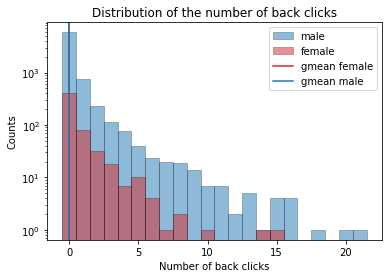

In [1584]:
plot_2_dist("number_backclicks", people_target_paths, 
            my_title="Distribution of the number of back clicks", my_xlabel="Number of back clicks", my_ylabel="Counts", ylog = True)

The number of backclicks is not significant, even if you look at all the people articles we have. 

#### **Difficulty rating**

**Difficulty rating of finished articles**

In [1585]:
wdiffrating_mean, naive_summary = bootstrap_metric("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], "female",
                                   estimator = 'Geometric', ci = 0.9, summary= naive_summary)

mdiffrating_mean, naive_summary = bootstrap_metric("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], "male",
                                   estimator = 'Geometric', ci = 0.9, summary= naive_summary)

female: Geometric mean: 2.2019182366215433
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [2.081, 2.323]
male: Geometric mean: 1.9633108018710008
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.936, 1.992]


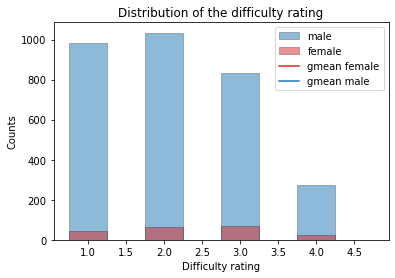

In [1586]:
plot_2_dist("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], bins=np.arange(1-0.25,5+0.25,0.5),
            my_title="Distribution of the difficulty rating", my_xlabel="Difficulty rating", my_ylabel="Counts")

#### **Summary**

In summary we see, that at a confidence interval of 90%, we see a significant difference in 4 out of 6 metrics.

In [1587]:
summary_figure(naive_summary, len(people_target_paths), "nothing", "naive_summary", opacity=[1,1,1,1,0.4,1])

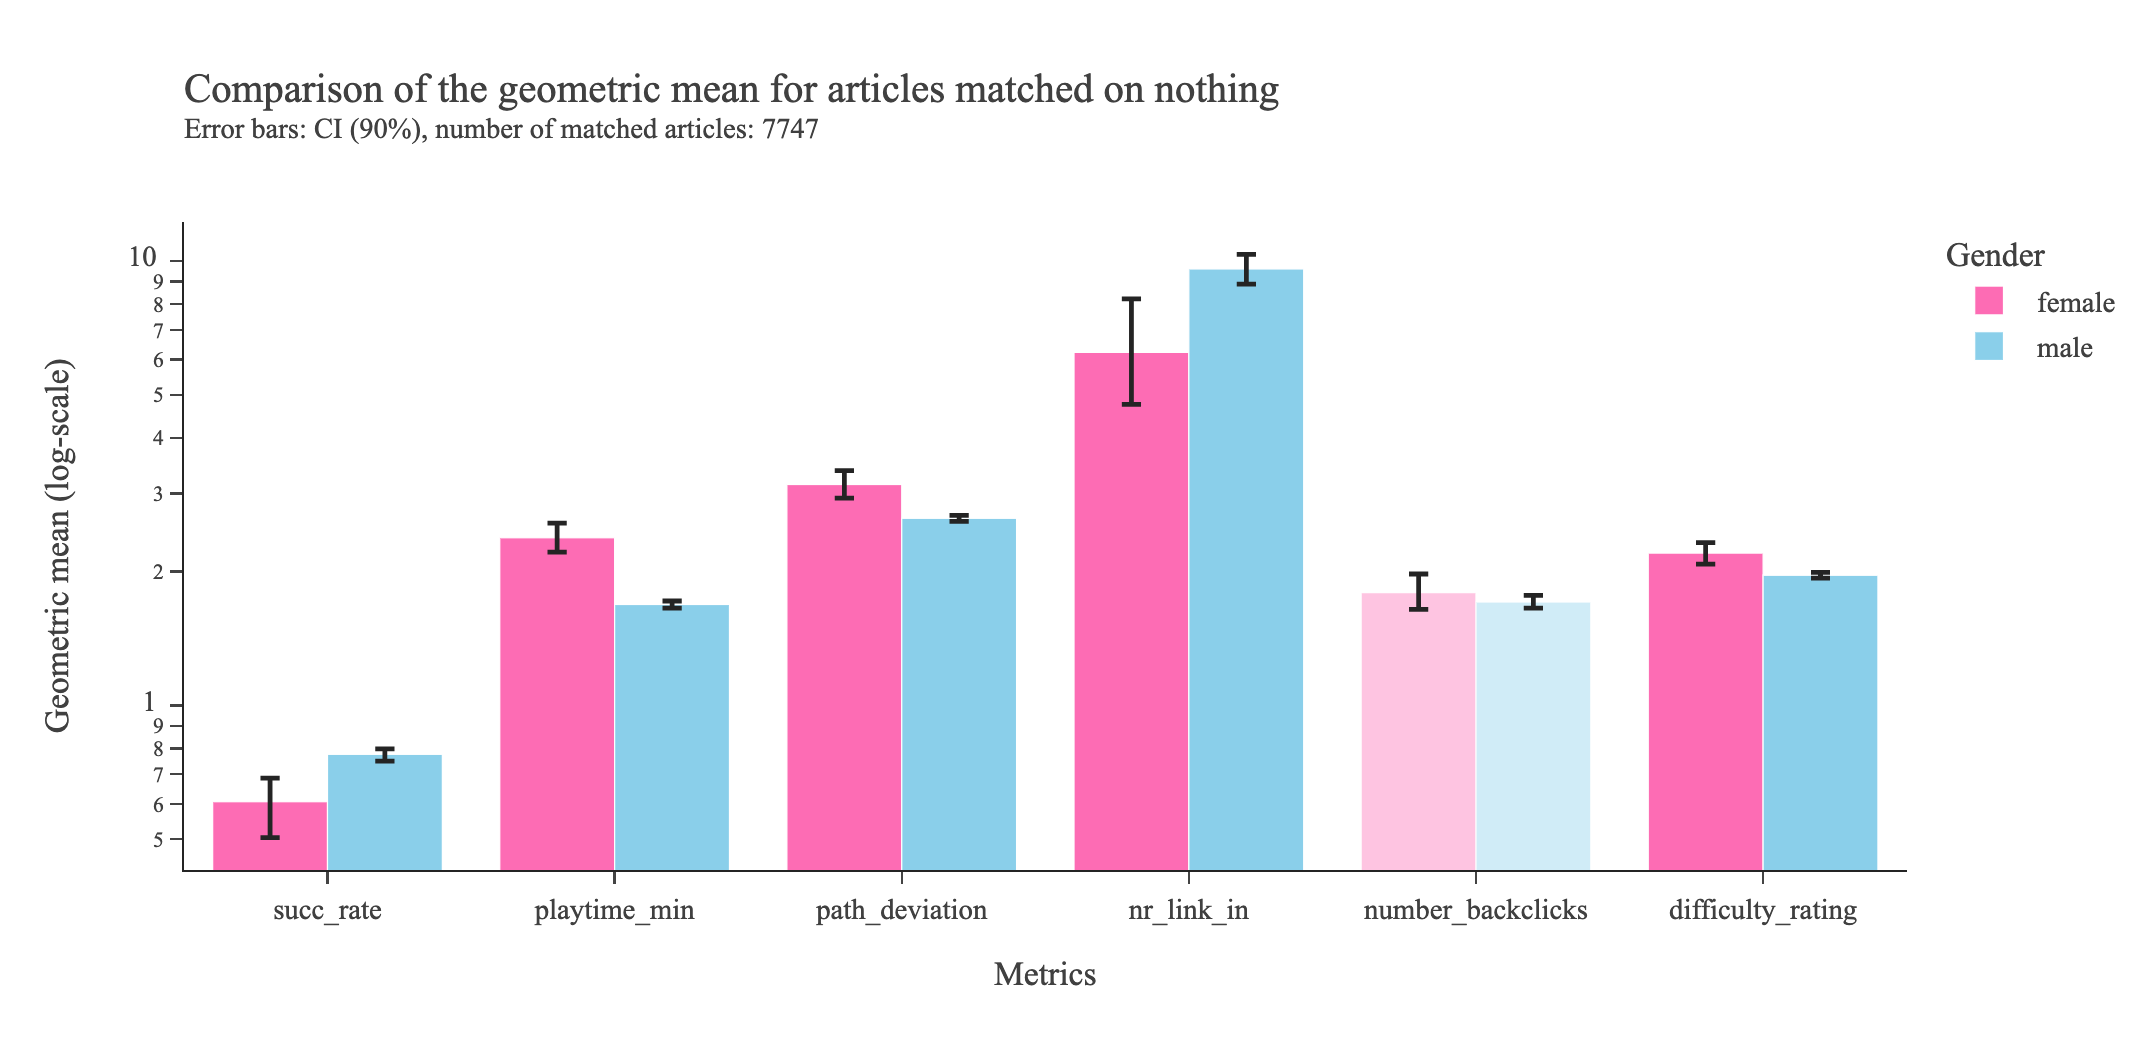

In [1588]:
Image(filename="images/smry_naive.png") #needed to display image

### **Controlling for all confounding factors**

Now, we will create pairs of paths that we will compare. The target articles of the pairs are a women article and a man article. Then, we can check for differences in the same metrics as in the naive analysis. 

#### **Matching**

In order to create the pairs, we need to match two target articles from the two groups of men and women articles. As mentioned in the README, the matching will be constrained by the following parameters:

1. starting a path at the same source article (minimum requirement of matching)
2. having the same shortest path length between a source article and a target article
3. having target articles in the same sub-category (e.g. male scientist vs. female scientist)
4. having target articles with a similiar or the same in_degree

The function `matching` matches two target articles from the control group (men) and from the treatment group (women) from our dataset. The `if`-statements handle each of the pre-defined constraints (from the minimum control to the strongest one). The function then returns three sets of four dataframes where each row corresponds to a path with a target article about a man or a woman with exactly one matched pair of the opposite gender. In the following sections, we will refer to the matching in the following way:
- (1): Paths matched only on same source
- (2): Paths matched on same source and shortest path link
- (3a): Paths matched on same source, shortest path link and category
- (3b): Paths matched on same source, shortest path link and similar in-degree

In [1589]:
def matching():
    # (1) match on source
    # (2) match on source and same shortest path link
    # (3a) match on source, same shortest path link and same category
    # (3b) match on source, same shortest path link and similar in-degree

    finished = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]
    unfinished = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]
    all_paths = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]

    for control_id, control_row in men_target_paths.iterrows():
        for treatment_id, treatment_row in women_target_paths.iterrows():
            # Add an edge only if the paths are both finished
            if (control_row['finished'] == True and treatment_row['finished'] == True):
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    finished[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        finished[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            finished[2].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article with the same or similar in-degree 
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            finished[3].add_weighted_edges_from([(control_id, treatment_id, 1)])    
                            
            # Add an edge only if the paths are both unfinished
            if (control_row['finished'] == False and treatment_row['finished'] == False):
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    unfinished[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        unfinished[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            unfinished[2].add_weighted_edges_from([(control_id, treatment_id, 1)]) 
                        
                        # Add an edge only if the paths have a target article with the same or similar in-degree 
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            unfinished[3].add_weighted_edges_from([(control_id, treatment_id, 1)])
                            
            # Add an edge between all possible paths, unfinished and finished             
            else:
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    all_paths[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        all_paths[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            all_paths[2].add_weighted_edges_from([(control_id, treatment_id, 1)])
                            
                        # Add an edge only if the paths have a target article with the same or similar in-degree 
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            all_paths[3].add_weighted_edges_from([(control_id, treatment_id, 1)])

    finished_dfs = []
    for g in finished:
        # get the matches and complete the dataframes depending on the matched articles
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        finished_dfs.append(balanced_df_all)
        
    unfinished_dfs = []
    for g in unfinished:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        unfinished_dfs.append(balanced_df_all)
    
    dfs = []
    for g in all_paths:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        dfs.append(balanced_df_all)

    return finished_dfs, unfinished_dfs, dfs

We also define the function `add_success_rate` that computes the success rate of reaching a target article and add its to a dataframe in a column called `success_rate`.

In [1590]:
# calculate success_rate for targets in their matching groups
# if target article only appears once, it will receive a NaN.  
def add_success_rate(df): 
    df = df.drop(columns = ["name"])
    fin = df[df['finished'] == True]["target"].value_counts().reindex(df.target.unique(), fill_value=0).rename("finished")
    tot = df["target"].value_counts().rename("total")

    temp=pd.concat([fin,tot],axis=1)
    temp.loc[temp["total"] > 1, 'success_rate'] = fin/tot

    success_rate = temp["success_rate"]
    df = df.merge(success_rate, how="left", left_on="target", right_index=True)
    return df

In the following code cell, we call both of these functions, the `add_success_rate` and `matching`, and save each returned dataframe to a file. We only do this once, since the function has a long run-time (which is the reason for why it is commented).

In [1591]:
# finished_dfs, unfinished_dfs, dfs = matching()

# dfs = [add_success_rate(df) for df in dfs]
# finished_dfs= [add_success_rate(df) for df in finished_dfs]
# unfinished_dfs = [add_success_rate(df) for df in unfinished_dfs]

# source_matching = dfs[0]
# source_matching.to_csv("./data/source_matched.csv")
# fin_source_matching = finished_dfs[0]
# fin_source_matching.to_csv("./data/fin_source_matched.csv")
# unfin_source_matching = unfinished_dfs[0]
# unfin_source_matching.to_csv("./data/unfin_source_matched.csv")

# src_shp_match = dfs[1]
# src_shp_match.to_csv("./data/src_and_shp_matched.csv")
# fin_src_shp_match = finished_dfs[1]
# fin_src_shp_match.to_csv("./data/fin_src_and_shp_matched.csv")
# unfin_src_shp_match = unfinished_dfs[1]
# unfin_src_shp_match.to_csv("./data/unfin_src_and_shp_matched.csv")

# cat_and_rest = dfs[2]
# cat_and_rest.to_csv("./data/cat_and_rest_matched.csv")
# fin_cat_and_rest = finished_dfs[2]
# fin_cat_and_rest.to_csv("./data/fin_cat_and_rest_matched.csv")
# unfin_cat_and_rest = unfinished_dfs[2]
# unfin_cat_and_rest.to_csv("./data/unfin_cat_and_rest_matched.csv")

# degree_and_rest = dfs[3]
# degree_and_rest.to_csv("./data/degree_and_rest_matched.csv")
# fin_degree_and_rest = finished_dfs[3]
# fin_degree_and_rest.to_csv("./data/fin_degree_and_rest_matched.csv")
# unfin_degree_and_rest = unfinished_dfs[3]
# unfin_degree_and_rest.to_csv("./data/unfin_degree_and_rest_matched.csv")

Here, we import the data, we just saved to a file. The following table gives an overview over the generated files of the matched data. *All paths* signifies that for example a finished path with a man article target can be paired to an unfinished path with woman article target, *Finished paths* signifies that only a finished path can be paired to another finished path of the opposite gender and *Unfinished paths* signifies that only an unfinished path can be paired to another unfinished path of the opposite gender.

| **Name of dataframe**      | **Matched paths**                                                     |
|----------------------|---------------------------------------------------------------------|
| src_match               | (1) All paths                                   |
| shpath_match               | (2) All paths                                    |
| cat_match             | (3a) All paths                         |
| degree_match             | (3b) All paths                          |
| fin_src_match    | (1) Finished paths|
| fin_shpath_match | (2) Finished paths                   |
| fin_cat_match        | (3a) Finished paths                                                   |
| fin_degree_match        | (3b) Finished paths                                                  |
| unfin_src_match    | (1) Unfinished paths |
| unfin_shpath_match | (2) Unfinished paths                    |
| unfin_cat_match        | (3a) Unfinished paths                                                   |
| unfin_degree_match        | (3b) Unfinished paths                                                   |


In [1592]:
src_match = pd.read_csv(DATA_FOLDER+"source_matched.csv").drop(columns = ['Unnamed: 0'])
shpath_match = pd.read_csv(DATA_FOLDER+"src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
cat_match = pd.read_csv(DATA_FOLDER+"cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
degree_match = pd.read_csv(DATA_FOLDER+"degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])

fin_src_match = pd.read_csv(DATA_FOLDER+"fin_source_matched.csv").drop(columns = ['Unnamed: 0'])
fin_shpath_match = pd.read_csv(DATA_FOLDER+"fin_src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
fin_cat_match = pd.read_csv(DATA_FOLDER+"fin_cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
fin_degree_match = pd.read_csv(DATA_FOLDER+"fin_degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])

unfin_src_match = pd.read_csv(DATA_FOLDER+"unfin_source_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_shpath_match = pd.read_csv(DATA_FOLDER+"unfin_src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_cat_match = pd.read_csv(DATA_FOLDER+"unfin_cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_degree_match = pd.read_csv(DATA_FOLDER+"unfin_degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])

The number of matched paths on each of our constraints can be seen in the following table and plot:

In [1593]:
comb_source = len(src_match)
comb_source_f = len(fin_src_match)
comb_source_u = len(unfin_src_match)

comb_shpath = len(shpath_match)
comb_shpath_f = len(fin_shpath_match)
comb_shpath_u = len(unfin_shpath_match)

comb_category = len(cat_match)
comb_category_f = len(fin_cat_match)
comb_category_u = len(unfin_cat_match)

comb_degree = len(degree_match)
comb_degree_f = len(fin_degree_match)
comb_degree_u = len(unfin_degree_match)

d = {'combination': ['Control on source','Control on source and shortest path length', 
                     'Control on source, shortest path length and category', 
                     'Control on source, shortest path length and in-degree'], 
    'all paths': [comb_source, comb_shpath, comb_category, comb_degree],
     'finished paths': [comb_source_f, comb_shpath_f, comb_category_f, comb_degree_f],
    'unfinished paths' : [comb_source_u, comb_shpath_u, comb_category_u, comb_degree_u]}

combinations = pd.DataFrame(data=d, index=[ 'source',
                                            'source and shortest path length', 
                                            'source, shortest path length and category', 
                                            'source, shortest path length and in-degree'])

In [1594]:
combinations[['all paths','finished paths', 'unfinished paths']]

,all paths,finished paths,unfinished paths
source,572,286,114
source and shortest path length,306,158,50
"source, shortest path length and category",22,12,6
"source, shortest path length and in-degree",216,98,40


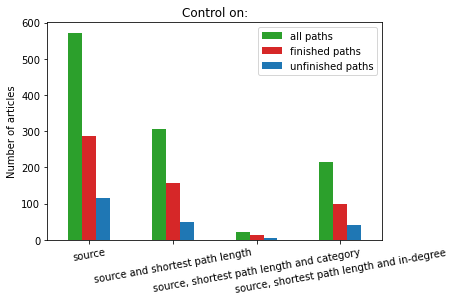

In [1595]:
ax = combinations.plot.bar(rot=10, stacked = False, color = ['tab:green','tab:red', 'tab:blue'], 
                           title = "Control on:",
                           ylabel = "Number of articles", width = 0.5)
plt.show()

#### **Controlled statistical analysis**

While working on the comparisons, we have tried multiple approaches. One of them was doing a quantile regression on the median. The following function combines all relevant steps to perform a descriptive linear regression. As we have decided on using the bootstrapped confidence intervals of the geometric mean, we used this function to verify and compare our results. The reason for not using the linear regression for all significant checks was the low adjusted-R value, telling us the regression does not fit the data well. 

In [1596]:
def quantile_regression(column, dataframe, my_title="", my_xlabel = "", my_ylabel = ""):
    mod = smf.quantreg(f'{column} ~ gender', dataframe).fit(q=0.5)
    print(mod.summary())
    conf = mod.conf_int()
    median_female = mod.params["Intercept"]
    median_male = median_female + mod.params["gender[T.male]"]
    uerr_female = conf.loc["Intercept"][1]-median_female
    lerr_female = conf.loc["Intercept"][1]-median_female
    uerr_male =  median_male - (median_female + conf.loc["gender[T.male]"][0])
    lerr_male =  median_male- (median_female + conf.loc["gender[T.male]"][0])
    error = np.array([[lerr_female, lerr_male], [uerr_female, uerr_male]])

    # Create lists for the plot
    genders = ['female', 'male']
    x_pos = np.arange(len(genders))
    medians = [median_female, median_male]

    fig, ax = plt.subplots()
    ax.bar(x_pos, medians, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(my_ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(genders)
    ax.set_title(my_title)
    ax.yaxis.grid(True)


    at = AnchoredText(f"pairs = {int(dataframe[column].size/2)}", loc='lower right', prop=dict(size=8), frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.show()

### **(1): Match on source**

The following part, repeats the procedure of the naive statistical analysis but with the dataframe containing the source matched articles. We have the following relevant datasets available:

| **Name of dataframe**      | **Matched paths**                                                     |
|----------------------|---------------------------------------------------------------------|
| src_match               | (1) All paths                                   |
| fin_src_match    | (1) Finished paths |
| unfin_src_match    | (1) Unfinished paths |

In [1597]:
# initialize summary dataframe
src_match_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])

#### **Success rate**

In [1598]:
# ALL PATHS matched
g_mean, src_match_summary = bootstrap_metric("success_rate", src_match, "female", summary=src_match_summary, ci = 0.9)
g_mean, src_match_summary = bootstrap_metric("success_rate", src_match, "male", summary=src_match_summary, ci = 0.9)

female: Geometric mean: 0.4638913702442112
female: 90.0% confidence interval of the geometric mean of success_rate: [0.424, 0.504]
male: Geometric mean: 0.8710690904118007
male: 90.0% confidence interval of the geometric mean of success_rate: [0.838, 0.900]


We can see a significant difference of the success rate means on source matched articles. 

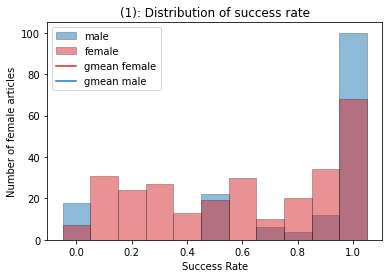

In [1599]:
plot_2_dist("success_rate", src_match, bins = np.arange(0-0.05, 1+0.15, 0.1),
            my_ylabel="Number of female articles", my_xlabel="Success Rate", my_title="(1): Distribution of success rate")

#### **Playtime**

In [1600]:
# FINISHED PATHS matched
g_mean, src_match_summary = bootstrap_metric("playtime_min", fin_src_match, "female", summary=src_match_summary)
g_mean, src_match_summary = bootstrap_metric("playtime_min", fin_src_match, "male", summary=src_match_summary)

female: Geometric mean: 2.3423288471044947
female: 90.0% confidence interval of the geometric mean of playtime_min: [2.078, 2.638]
male: Geometric mean: 1.5417810224667179
male: 90.0% confidence interval of the geometric mean of playtime_min: [1.359, 1.736]


The playtime has a significant difference as well.

#### **Path deviation**

In [1601]:
# FINISHED PATHS matched
g_mean, src_match_summary= bootstrap_metric("path_deviation", fin_src_match, "female", ci=0.9, summary=src_match_summary)
g_mean, src_match_summary= bootstrap_metric("path_deviation", fin_src_match, "male", ci=0.9, summary= src_match_summary)

female: Geometric mean: 2.868222434338483
female: 90.0% confidence interval of the geometric mean of path_deviation: [2.557, 3.229]
male: Geometric mean: 2.28099895895486
male: 90.0% confidence interval of the geometric mean of path_deviation: [2.063, 2.537]


#### **In-degree**

In [1602]:
# FINISHED PATHS matched
g_mean, src_match_summary = bootstrap_metric("nr_link_in", fin_src_match, "female", summary=src_match_summary, ci=0.9)
g_mean, src_match_summary = bootstrap_metric("nr_link_in", fin_src_match, "male", summary=src_match_summary, ci=0.9)

female: Geometric mean: 12.603176593017102
female: 90.0% confidence interval of the geometric mean of nr_link_in: [10.783, 14.783]
male: Geometric mean: 18.42099759840253
male: 90.0% confidence interval of the geometric mean of nr_link_in: [15.984, 21.162]


#### **Number of back clicks**

In [1603]:
# ALL PATHS matched
g_mean, src_match_summary= bootstrap_metric("number_backclicks", src_match, "female", ci=0.9, summary= src_match_summary)
g_mean, src_match_summary= bootstrap_metric("number_backclicks", src_match, "male", ci=0.9, summary= src_match_summary)

female: Geometric mean: 1.7572296754332428
female: 90.0% confidence interval of the geometric mean of number_backclicks: [1.537, 2.079]
male: Geometric mean: 1.8083328980338347
male: 90.0% confidence interval of the geometric mean of number_backclicks: [1.556, 2.148]


#### **Difficulty rating**

In [1604]:
# FINISHED PATHS matched
g_mean, src_match_summary= bootstrap_metric("difficulty_rating", fin_src_match, "female", ci=0.9, summary=src_match_summary)
g_mean, src_match_summary = bootstrap_metric("difficulty_rating", fin_src_match, "male", ci=0.9, summary = src_match_summary)

female: Geometric mean: 2.1461710335086894
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.972, 2.333]
male: Geometric mean: 1.916266300686311
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.747, 2.110]


#### **Summary**

In summary we can see that as soon as we control on the source, which was our minimum requirement we do not see a significant difference in number of backclicks and the difficuly rating anymore. The other metrics, while having a decreased distance in mean can still be considered significant at a 90 % Confidence Interval. 

In [1605]:
summary_figure(src_match_summary, f"{len(src_match)} ({len(fin_src_match)} finished)", "source", "src_match", opacity = [1,1,1,1,0.4, 0.4])

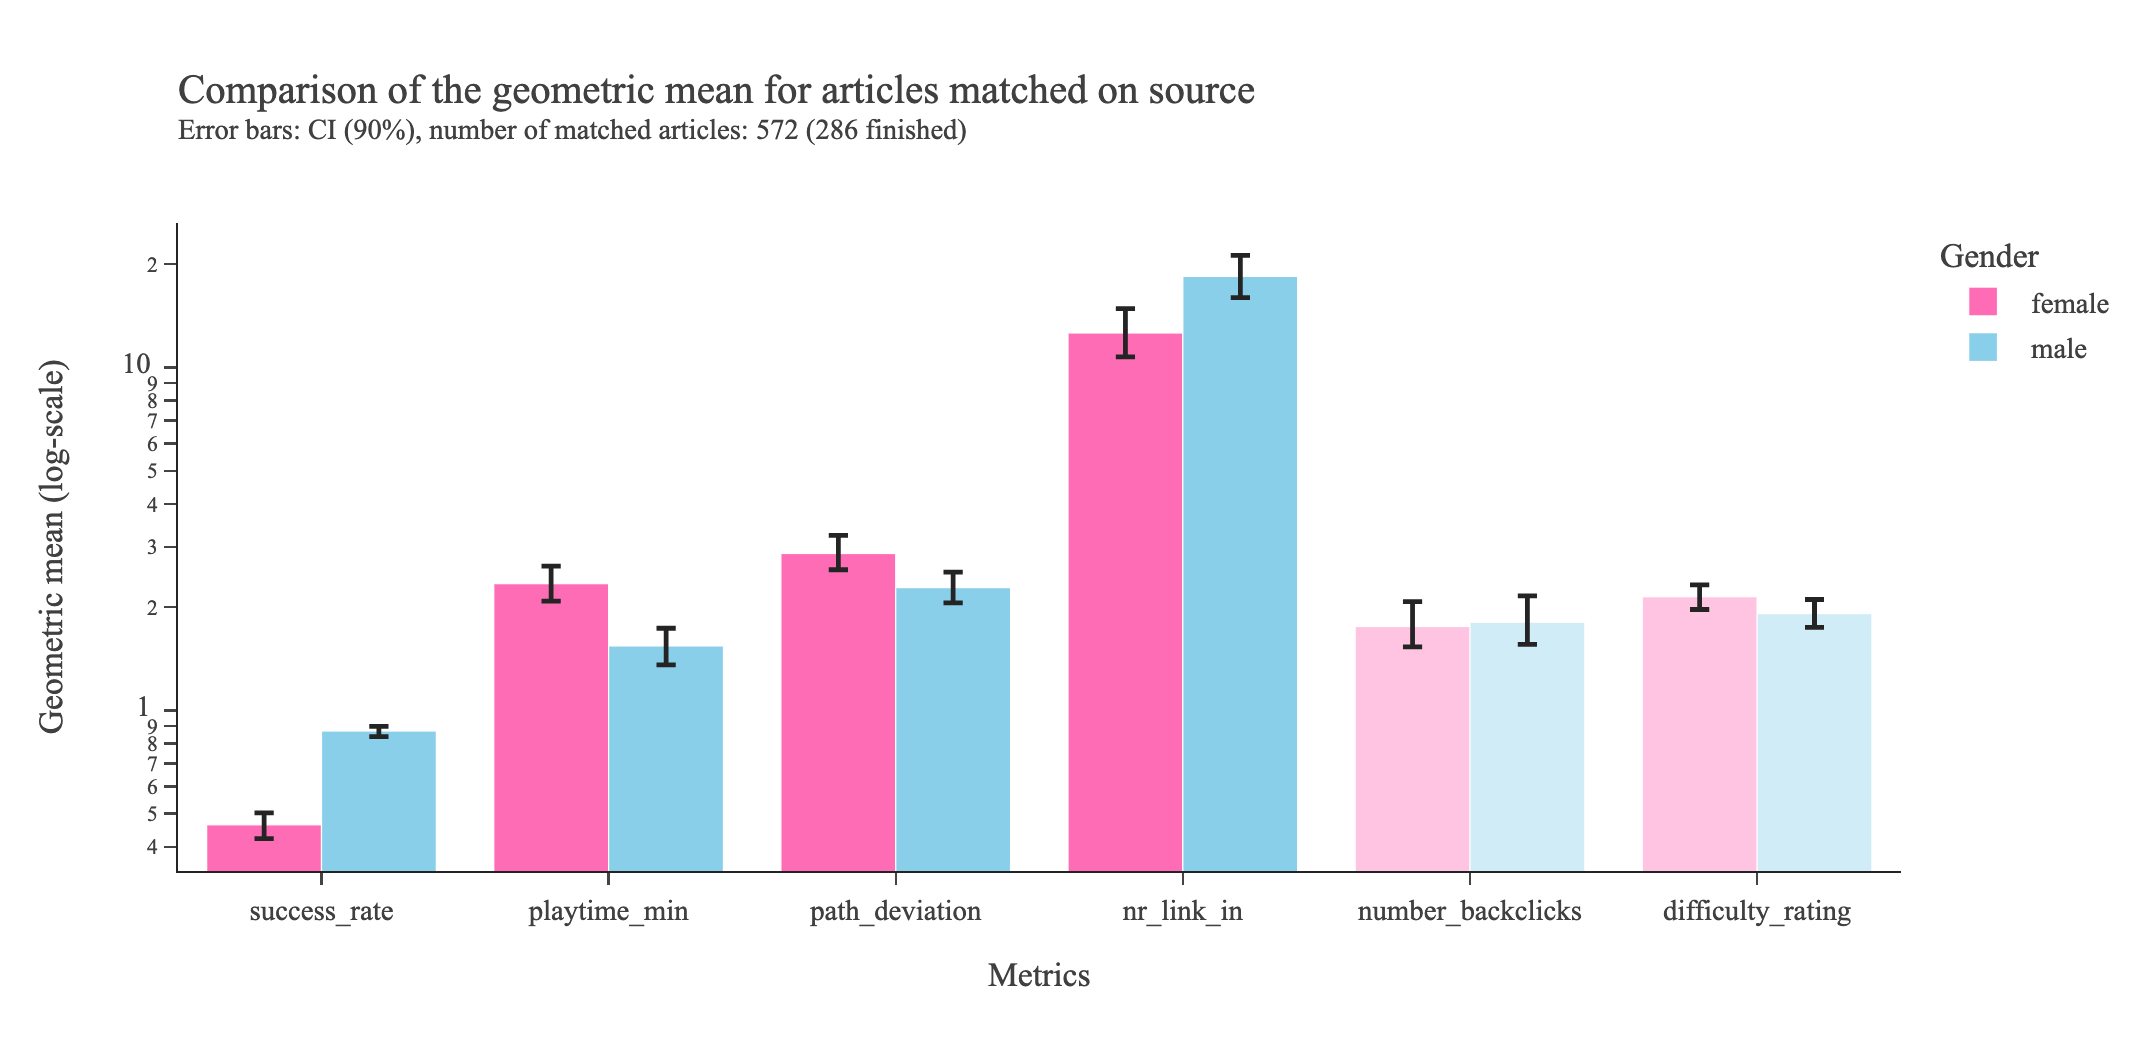

In [1606]:
Image(filename="images/smry_source.png") #needed to display image

### **(2): Match on source and shortest path length**

| **Name of dataframe**      | **Matched paths**                                                     |
|----------------------|---------------------------------------------------------------------|
| shpath_match               | (2) All paths                                   |
| fin_shpath_match    | (2) Finished paths |
| unfin_shpath_match    | (2) Unfinished paths |

In [1607]:
shpath_match_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])

#### **Success rate**

In [1608]:
# ALL PATHS matched
g_mean, shpath_match_summary = bootstrap_metric("success_rate", shpath_match, "female", ci=0.9, summary= shpath_match_summary)
g_mean, shpath_match_summary = bootstrap_metric("success_rate", shpath_match, "male", ci=0.9, summary= shpath_match_summary)

female: Geometric mean: 0.5876958125740577
female: 90.0% confidence interval of the geometric mean of success_rate: [0.533, 0.638]
male: Geometric mean: 0.9248881014491848
male: 90.0% confidence interval of the geometric mean of success_rate: [0.877, 0.955]


                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:               0.1549
Model:                       QuantReg   Bandwidth:                      0.2844
Method:                 Least Squares   Sparsity:                       0.8337
Date:                Wed, 21 Dec 2022   No. Observations:                  219
Time:                        20:28:46   Df Residuals:                      217
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6667      0.035     19.192      0.000       0.598       0.735
gender[T.male]     0.3333      0.059      5.616      0.000       0.216       0.450


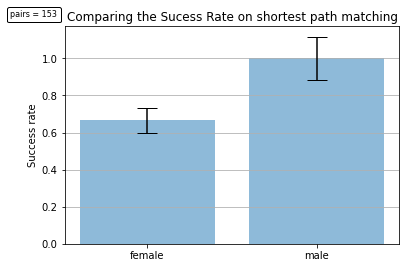

In [1609]:
quantile_regression("success_rate", shpath_match, my_title="Comparing the Sucess Rate on shortest path matching", my_xlabel="Gender", my_ylabel="Success rate")

#### **Playtime**

In [1610]:
# FINISHED PATHS matched
g_mean, shpath_match_summary = bootstrap_metric("playtime_min", fin_shpath_match, "female", ci=0.9, summary= shpath_match_summary)
g_mean, shpath_match_summary = bootstrap_metric("playtime_min", fin_shpath_match, "male", ci=0.9, summary= shpath_match_summary)

female: Geometric mean: 2.2146861069353587
female: 90.0% confidence interval of the geometric mean of playtime_min: [1.932, 2.575]
male: Geometric mean: 1.7819621794695775
male: 90.0% confidence interval of the geometric mean of playtime_min: [1.546, 2.064]


#### **Path deviation**

In [1611]:
# FINISHED PATHS matched
g_mean, shpath_match_summary = bootstrap_metric("path_deviation", fin_shpath_match, "female", ci=0.9, summary= shpath_match_summary)
g_mean, shpath_match_summary = bootstrap_metric("path_deviation", fin_shpath_match, "male", ci=0.9, summary= shpath_match_summary)

female: Geometric mean: 2.664617066028386
female: 90.0% confidence interval of the geometric mean of path_deviation: [2.343, 3.087]
male: Geometric mean: 2.3869054293062617
male: 90.0% confidence interval of the geometric mean of path_deviation: [2.092, 2.774]


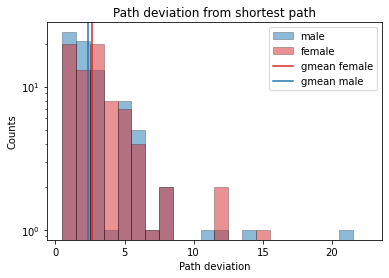

In [1612]:
plot_2_dist("path_deviation", fin_shpath_match, 
            my_title="Path deviation from shortest path", my_xlabel="Path deviation", my_ylabel="Counts", ylog=True)

#### **In-degree**

In [1613]:
g_mean, shpath_match_summary = bootstrap_metric("nr_link_in", fin_shpath_match, "female", summary=shpath_match_summary, ci=0.9)
g_mean, shpath_match_summary = bootstrap_metric("nr_link_in", fin_shpath_match, "male", summary=shpath_match_summary, ci=0.9)

female: Geometric mean: 15.781894146699083
female: 90.0% confidence interval of the geometric mean of nr_link_in: [12.979, 19.431]
male: Geometric mean: 18.942968722518348
male: 90.0% confidence interval of the geometric mean of nr_link_in: [15.725, 22.850]


#### **Number of back clicks**

In [1614]:
# ALL PATHS matched
g_mean, shpath_match_summary = bootstrap_metric("number_backclicks", shpath_match, "female", ci=0.9, summary= shpath_match_summary)
g_mean, shpath_match_summary = bootstrap_metric("number_backclicks", shpath_match, "male", ci=0.9, summary= shpath_match_summary)

female: Geometric mean: 1.742575776141812
female: 90.0% confidence interval of the geometric mean of number_backclicks: [1.485, 2.161]
male: Geometric mean: 1.972526648610801
male: 90.0% confidence interval of the geometric mean of number_backclicks: [1.585, 2.606]


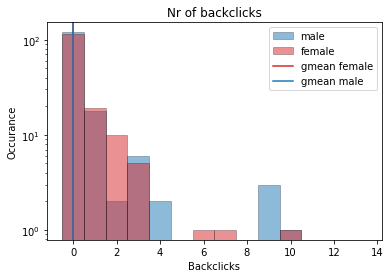

In [1615]:
plot_2_dist("number_backclicks", shpath_match, my_title="Nr of backclicks", my_xlabel="Backclicks", my_ylabel="Occurance", ylog=True)

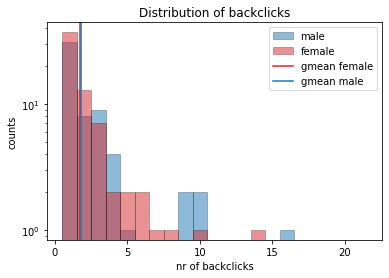

In [1616]:
# the backclicks that differ from 0
backclicks = src_match[src_match["number_backclicks"]!= 0]
plot_2_dist("number_backclicks", backclicks, 
            my_title="Distribution of backclicks", my_xlabel="nr of backclicks", my_ylabel="counts", ylog=True)

#### **Difficulty rating**

In [1617]:
# FINISHED PATHS matched
g_mean, shpath_match_summary = bootstrap_metric("difficulty_rating", fin_shpath_match, "female", ci=0.9, summary= shpath_match_summary)
g_mean, shpath_match_summary = bootstrap_metric("difficulty_rating", fin_shpath_match, "male", ci=0.9, summary= shpath_match_summary)

female: Geometric mean: 1.9544654848281908
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.748, 2.164]
male: Geometric mean: 2.0654610525799098
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.806, 2.366]


#### **Summary**

Matching on source and shortest path length and repeating the analysis, shows that now only the success rate has a significant difference in mean. However the tendencies stay the same, meaning that the playtime and path deviation of women is still higher. Given more data or a more stratified matching might lead to signifant results at this stage of the analysis. 

In [1618]:
summary_figure(shpath_match_summary,f"{len(shpath_match)} ({len(fin_shpath_match)} finished)", 
            "source and shortest path length", "shpath_match", opacity = [1,0.4,0.4,0.4,0.4, 0.4])

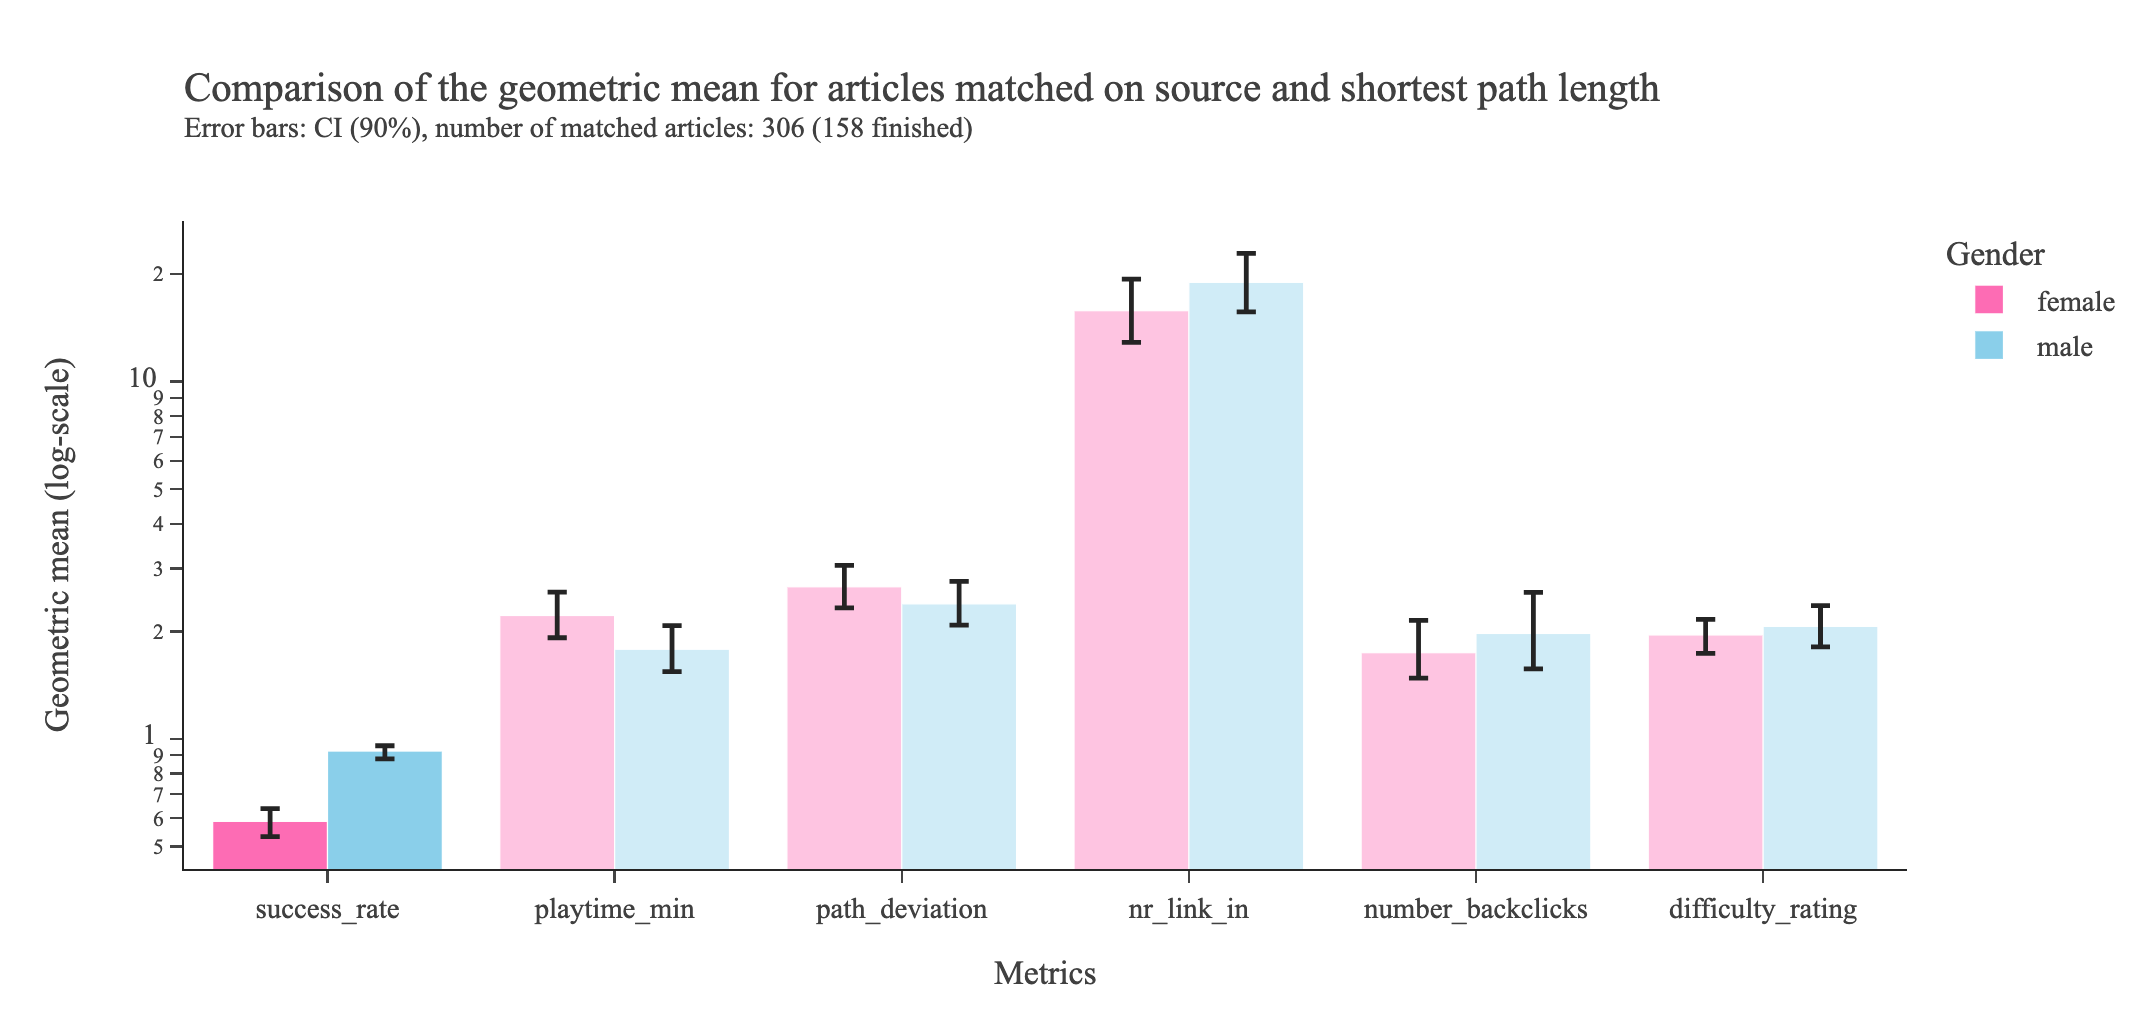

In [1619]:
Image(filename="images/smry_shp.png") #needed to display image

### **(3a): Match on source, shortest path length and categories**

In the next step we have matched on source, shortest path length and categories. After repeating the analysis we have decided not to continue with it as we did not have enough datapoints left after the matching. This is mainly due to the many categories where women are not present at all.

| **Name of dataframe**      | **Matched paths**                                                     |
|----------------------|---------------------------------------------------------------------|
| cat_match               | (3a) All paths                                   |
| fin_cat_match    | (3a) Finished paths |
| unfin_cat_match    | (3a) Unfinished paths |


In [1620]:
cat_match_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])

#### **Success rate**

In [1621]:
# ALL PATHS matched
#g_mean, cat_match_summary = bootstrap_metric("success_rate", cat_match, "female", ci=0.9, summary = cat_match_summary)
#g_mean, cat_match_summary = bootstrap_metric("success_rate", cat_match, "male", ci=0.9, summary = cat_match_summary)

#### **Playtime**

In [1622]:
# FINISHED PATHS matched
g_mean, cat_match_summary = bootstrap_metric("playtime_min", fin_cat_match, "female", ci=0.9, summary = cat_match_summary)
g_mean, cat_match_summary = bootstrap_metric("playtime_min", fin_cat_match, "male", ci=0.9, summary = cat_match_summary)

female: Geometric mean: 3.9567849447628056
female: 90.0% confidence interval of the geometric mean of playtime_min: [1.714, 11.626]
male: Geometric mean: 1.9771218887790076
male: 90.0% confidence interval of the geometric mean of playtime_min: [1.359, 3.139]


#### **Path deviation**

In [1623]:
# FINISHED PATHS matched
g_mean, cat_match_summary = bootstrap_metric("path_deviation", fin_cat_match, "female", ci=0.9, summary = cat_match_summary)
g_mean, cat_match_summary = bootstrap_metric("path_deviation", fin_cat_match, "male", ci=0.9, summary = cat_match_summary)

female: Geometric mean: 2.6960123091945554
female: 90.0% confidence interval of the geometric mean of path_deviation: [1.348, 3.888]
male: Geometric mean: 1.8171205928321397
male: 90.0% confidence interval of the geometric mean of path_deviation: [1.122, 2.749]


#### **In-degree**

In [1624]:
g_mean, cat_match_summary = bootstrap_metric("nr_link_in", fin_cat_match, "female", ci=0.9, summary = cat_match_summary)
g_mean, cat_match_summary = bootstrap_metric("nr_link_in", fin_cat_match, "male", ci=0.9, summary = cat_match_summary)

female: Geometric mean: 25.318955645390872
female: 90.0% confidence interval of the geometric mean of nr_link_in: [12.233, 53.221]
male: Geometric mean: 21.74911744844637
male: 90.0% confidence interval of the geometric mean of nr_link_in: [16.510, 30.279]


#### **Number of back clicks**

In [1625]:
# ALL PATHS matched
#g_mean, cat_match_summary = bootstrap_metric("number_backclicks", cat_match, "female", ci=0.9, summary = cat_match_summary)
#g_mean, cat_match_summary = bootstrap_metric("number_backclicks", cat_match, "male", ci=0.9, summary = cat_match_summary)

#### **Difficulty rating**

In [1626]:
# FINISHED PATHS matched
g_mean, cat_match_summary = bootstrap_metric("difficulty_rating", cat_match, "female", ci=0.9, summary = cat_match_summary)
g_mean, cat_match_summary = bootstrap_metric("difficulty_rating", cat_match, "male", ci=0.9, summary = cat_match_summary)

female: Geometric mean: 2.550849001251582
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [2.000, 2.766]
male: Geometric mean: 2.352158045049347
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.431, 3.000]


#### **Summary**

In [1627]:
cat_match_summary

,metric,gender,gmean,ci_0,ci_1
0,playtime_min,female,3.956785,1.714414,11.626328
1,playtime_min,male,1.977122,1.359199,3.138703
2,path_deviation,female,2.696012,1.348006,3.888323
3,path_deviation,male,1.817121,1.122462,2.749459
4,nr_link_in,female,25.318956,12.233255,53.220611
5,nr_link_in,male,21.749117,16.509636,30.279443
6,difficulty_rating,female,2.550849,2.0,2.766324
7,difficulty_rating,male,2.352158,1.430969,3.0


In [1628]:
summary_figure(cat_match_summary,f"{len(cat_match)} ({len(fin_cat_match)} finished)", "source, shortest path length and category", "cat_match", opacity = [0.4,0.4,0.4,0.4,0.4])

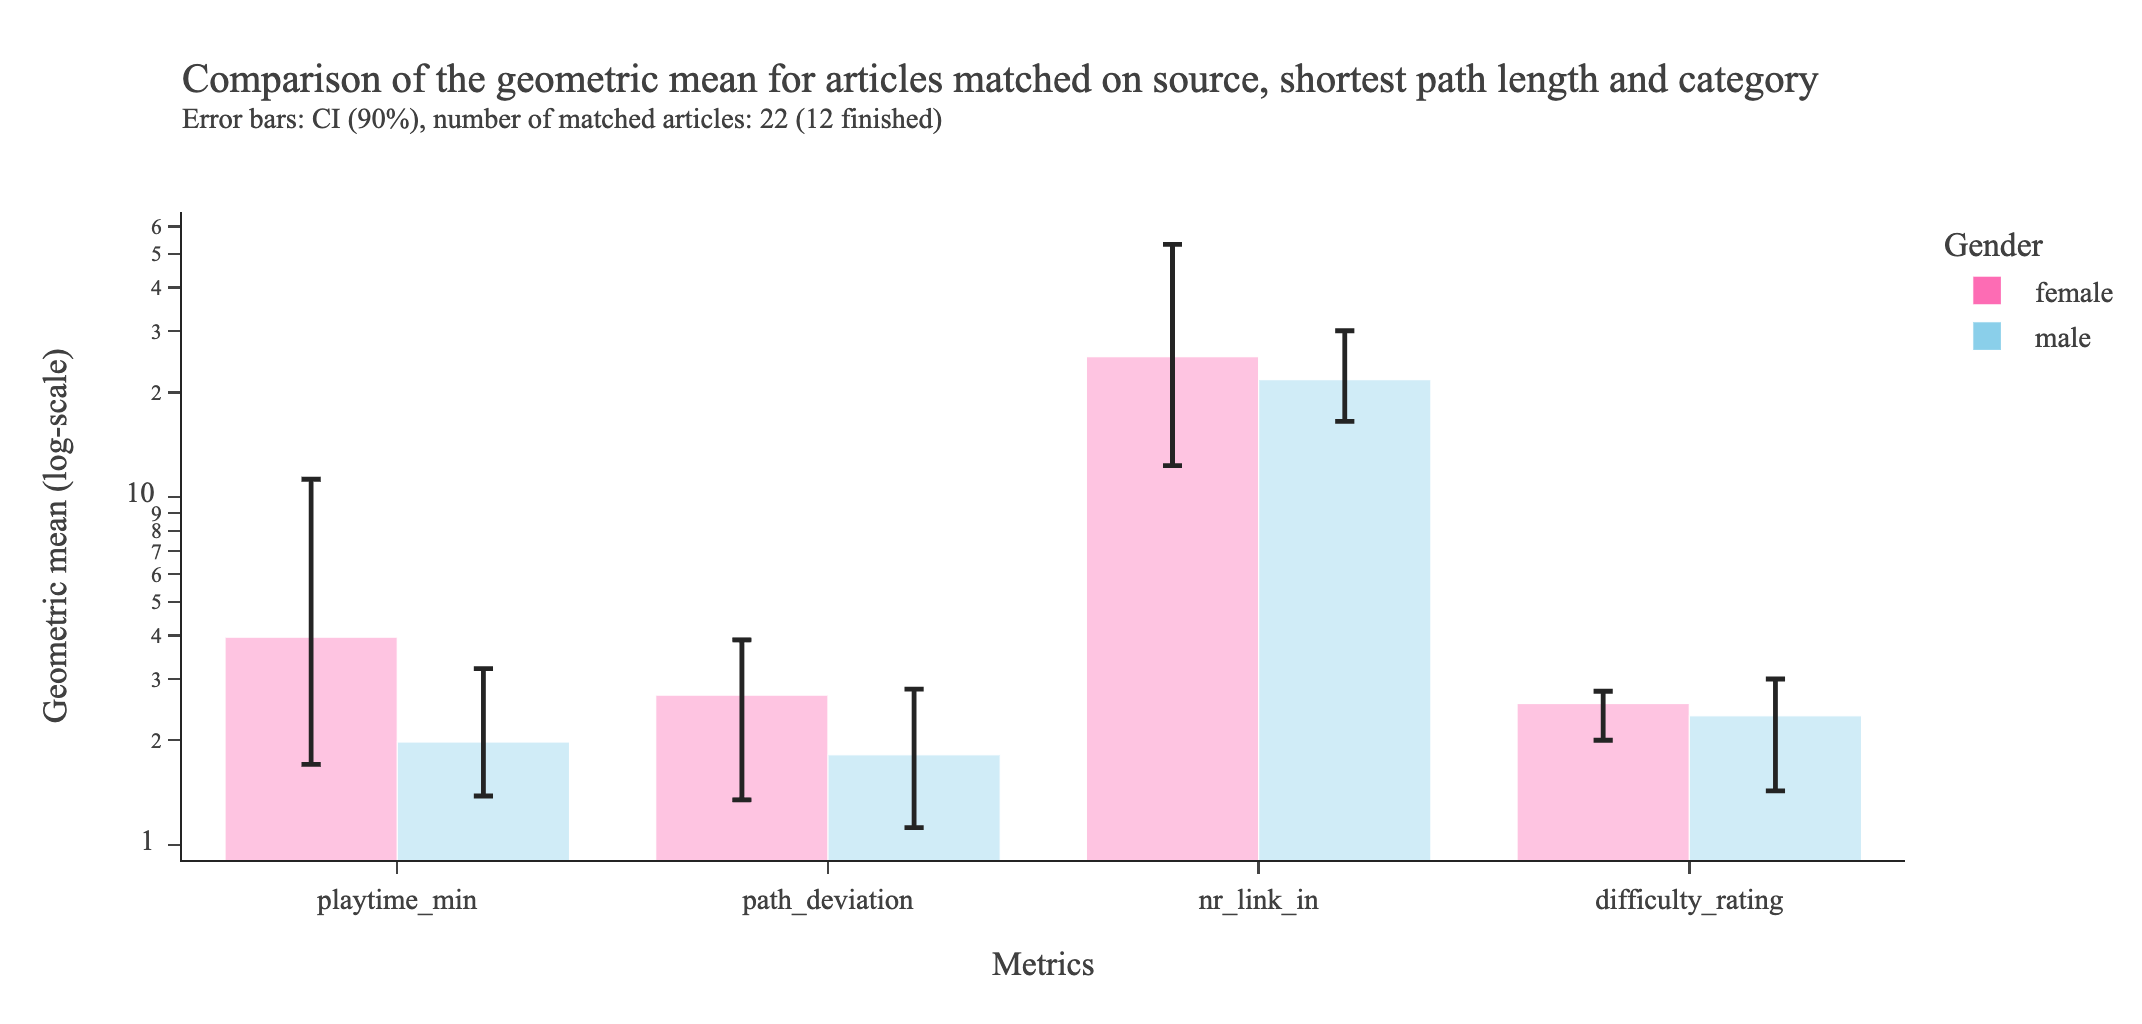

In [1629]:
Image(filename="images/smry_cat.png") #needed to display image

We can observe the large confidence intervals due to the low number of datapoints.

### **(3b): Match on source, shortest path length and in-degree**

As a variation of the previous step, we have matched on source, shortest path length and the in-degree. To prevent, having the same problem as above we have grouped the 77 unique in-degree values to 10 evenly sized groups (see in data preprocessing). Now, target articles that have the same representative group out of the 10, can be compared.

| **Name of dataframe**      | **Matched paths**                                                     |
|----------------------|---------------------------------------------------------------------|
| degree_match               | (3b) All paths                                   |
| fin_degree_match    | (3b) Finished paths |
| unfin_degree_match    | (3b) Unfinished paths |

In [1630]:
degree_match_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])

#### **Success rate**

In [1631]:
# ALL PATHS matched
g_mean, degree_match_summary = bootstrap_metric("success_rate", degree_match, "female", ci=0.9, summary = degree_match_summary)
g_mean, degree_match_summary = bootstrap_metric("success_rate", degree_match, "male", ci=0.9, summary = degree_match_summary)

female: Geometric mean: 0.5695552949267243
female: 90.0% confidence interval of the geometric mean of success_rate: [0.516, 0.623]
male: Geometric mean: 0.9186269540704759
male: 90.0% confidence interval of the geometric mean of success_rate: [0.844, 0.945]


#### **Playtime**

In [1632]:
# FINISHED PATHS matched
g_mean, degree_match_summary = bootstrap_metric("playtime_min", fin_degree_match, "female", ci=0.9, summary = degree_match_summary)
g_mean, degree_match_summary = bootstrap_metric("playtime_min", fin_degree_match, "male", ci=0.9, summary = degree_match_summary)

female: Geometric mean: 2.4966532110486086
female: 90.0% confidence interval of the geometric mean of playtime_min: [2.099, 3.019]
male: Geometric mean: 2.2401291478161554
male: 90.0% confidence interval of the geometric mean of playtime_min: [1.863, 2.714]


#### **Path deviation**

In [1633]:
# FINISHED PATHS matched
g_mean, degree_match_summary = bootstrap_metric("path_deviation", fin_degree_match, "female", ci=0.9, summary = degree_match_summary)
g_mean, degree_match_summary = bootstrap_metric("path_deviation", fin_degree_match, "male", ci=0.9, summary = degree_match_summary)

female: Geometric mean: 2.7815231004758134
female: 90.0% confidence interval of the geometric mean of path_deviation: [2.331, 3.358]
male: Geometric mean: 3.0894217828337016
male: 90.0% confidence interval of the geometric mean of path_deviation: [2.616, 3.726]


#### **Number of backclicks**

In [1634]:
# ALL PATHS matched
g_mean, degree_match_summary = bootstrap_metric("number_backclicks", degree_match, "female", ci=0.9, summary = degree_match_summary)
g_mean, degree_match_summary = bootstrap_metric("number_backclicks", degree_match, "male", ci=0.9, summary = degree_match_summary)

female: Geometric mean: 1.6940612677841544
female: 90.0% confidence interval of the geometric mean of number_backclicks: [1.400, 2.209]
male: Geometric mean: 2.2106664570866146
male: 90.0% confidence interval of the geometric mean of number_backclicks: [1.693, 3.050]


#### **Difficulty rating**

In [1635]:
# FINISHED PATHS matched
g_mean, degree_match_summary = bootstrap_metric("difficulty_rating", degree_match, "female", ci=0.9, summary = degree_match_summary)
g_mean, degree_match_summary = bootstrap_metric("difficulty_rating", degree_match, "male", ci=0.9, summary = degree_match_summary)

female: Geometric mean: 2.0801128417156494
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.792, 2.361]
male: Geometric mean: 2.315523756903526
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [2.050, 2.580]


#### **Summary**

In [1636]:
degree_match_summary

,metric,gender,gmean,ci_0,ci_1
0,success_rate,female,0.569555,0.515714,0.623098
1,success_rate,male,0.918627,0.843875,0.944988
2,playtime_min,female,2.496653,2.098752,3.018943
3,playtime_min,male,2.240129,1.863478,2.714364
4,path_deviation,female,2.781523,2.330661,3.357573
5,path_deviation,male,3.089422,2.615577,3.725762
6,number_backclicks,female,1.694061,1.399981,2.208504
7,number_backclicks,male,2.210666,1.69326,3.050349
8,difficulty_rating,female,2.080113,1.792242,2.360839
9,difficulty_rating,male,2.315524,2.049798,2.580045


In [1637]:
summary_figure(degree_match_summary, f"{len(degree_match)} ({len(fin_degree_match)} finished)", "source, shortest path length and in-degree", "degree_match", opacity = [1,0.4,0.4,0.4,0.4])

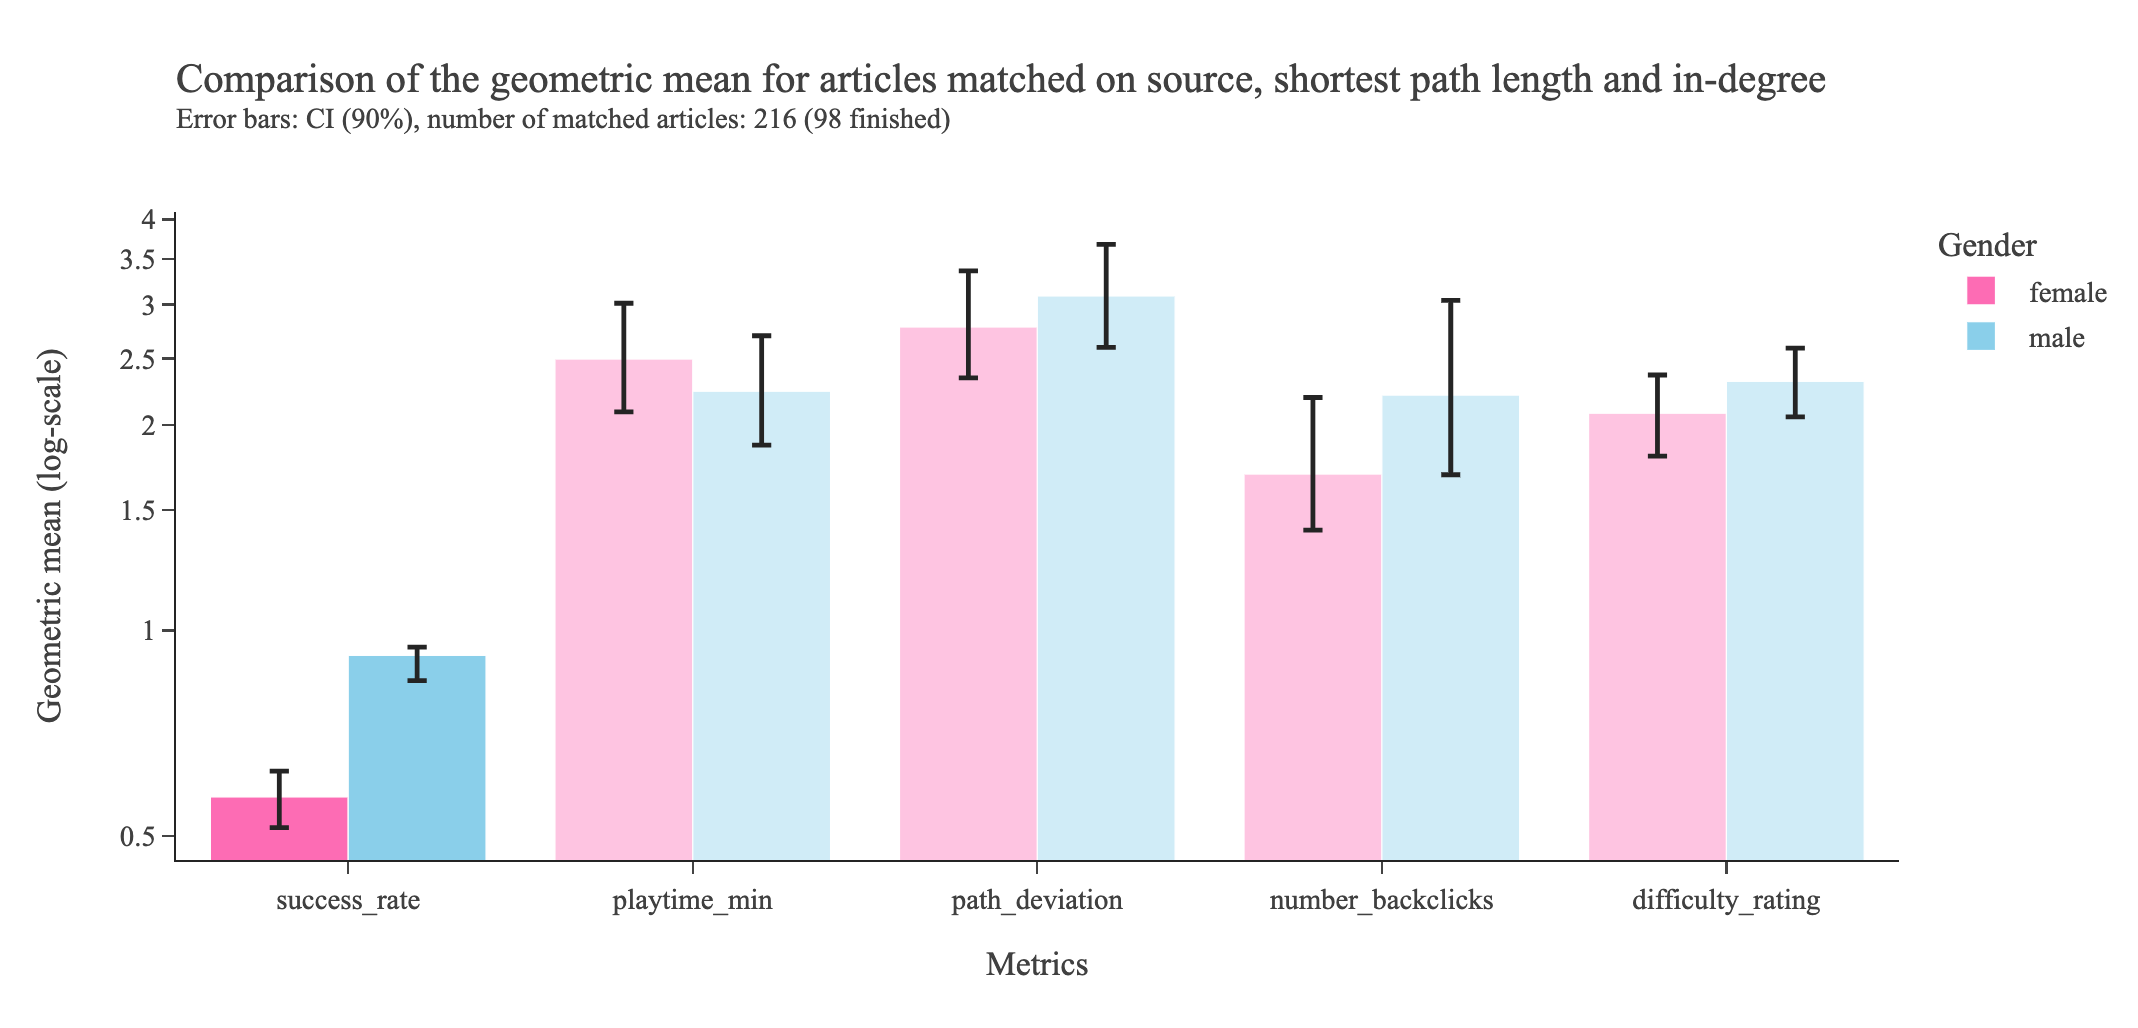

In [1638]:
Image(filename="images/smry_degree.png") #needed to display image

The initial assumption of a difference in success between a male and a female target article has been proven significant through all the steps. The two metrices *playtime* and *path_deviation*, which are both based on the additional constraint of finished paths have not been significant, as the number of datapoints has always been smaller. Again we note the large confidence intervals due to the high variation and low amount of data points. 

## **Visualizations for the datastory**

#### **Plot 1**

In [1639]:
nr_of_men = sum(men_people)
nr_of_women = sum(women_people)

nr_men_women = pd.DataFrame({'gender': ['women', 'men'],'number_of': [nr_of_women, nr_of_men], 
                             'y_value_to_align': [1,1], 'x_value_to_align': [0,1]})

total_people = nr_men_women['number_of'].sum()
nr_men_women['percentage'] = nr_men_women['number_of']/total_people*100
nr_men_women['percentage'] = nr_men_women['percentage'].round(2)
fig = go.Figure(data=[go.Scatter(
    x=nr_men_women['x_value_to_align'], y=nr_men_women['y_value_to_align'],
    text=nr_men_women['number_of'],
    mode='markers+text',
    marker=dict(
        color=['hotpink', 'skyblue'],
        opacity=[1, 1],
        size=[nr_of_women, nr_of_men/3]),
    hovertemplate=
        nr_men_women['percentage'].astype(str)+"%" +" of all articles about People are about "+nr_men_women['gender']+"")])

fig.update_layout(
    font_family="Helvetica",
    font_color="white",
    font_size=20,
    template = 'simple_white',
    width=500, height=400
)

fig.update_layout(title='Number of articles about men and women', title_font = dict(family='Times New Roman, serif', color = '#404040', size = 20))

fig.update_xaxes(visible=False)   
fig.update_yaxes(visible=False)
fig.show()

# to html only needed to save them for the datastory
# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot1.html", full_html=False, include_plotlyjs='cdn')


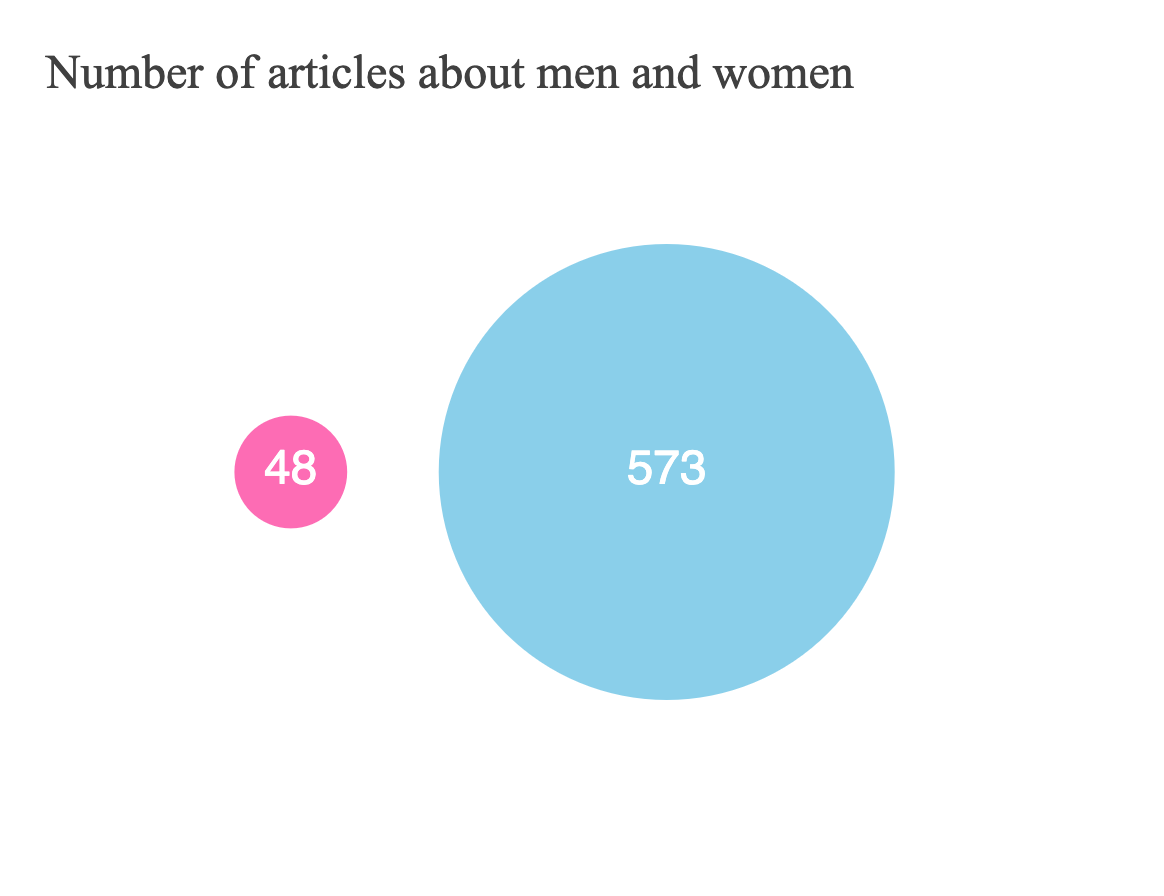

In [1640]:
Image(filename="images/plot1.png") #needed to display image

#### **Plot 2**

In [1641]:
women_count = people[people['gender'] == "female"]["category"].count()
men_count = people[people['gender'] == "male"]["category"].count()
number_of_people_per_cat = people.groupby("category")["gender"].count()
men_women_proportion = pd.DataFrame({'women': women_people/number_of_people_per_cat,'men': men_people/number_of_people_per_cat}, 
                                    index=index).sort_index()
men_women_proportion.fillna(0,inplace=True)

fig = px.bar(men_women_proportion, x='women')

fig = px.bar(men_women_proportion, 
             x = [category for category in men_women_proportion.columns],
             y = men_women_proportion.transpose().columns.str.replace('_', ' '),
             color_discrete_sequence = ['hotpink','skyblue'],
             title = 'Fraction of women and men articles within each category',
             labels={"y": "Categories",
                     "value": "Fraction of articles",
                     "variable": "Gender"},
             orientation='h',
             width=1000, height=600,
            template = 'simple_white')

fig.update_layout(font_color = '#404040', font_family='Times New Roman, serif', font_size = 14, yaxis=dict(title = None, autorange="reversed"))
fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot2.html", full_html=False, include_plotlyjs='cdn')

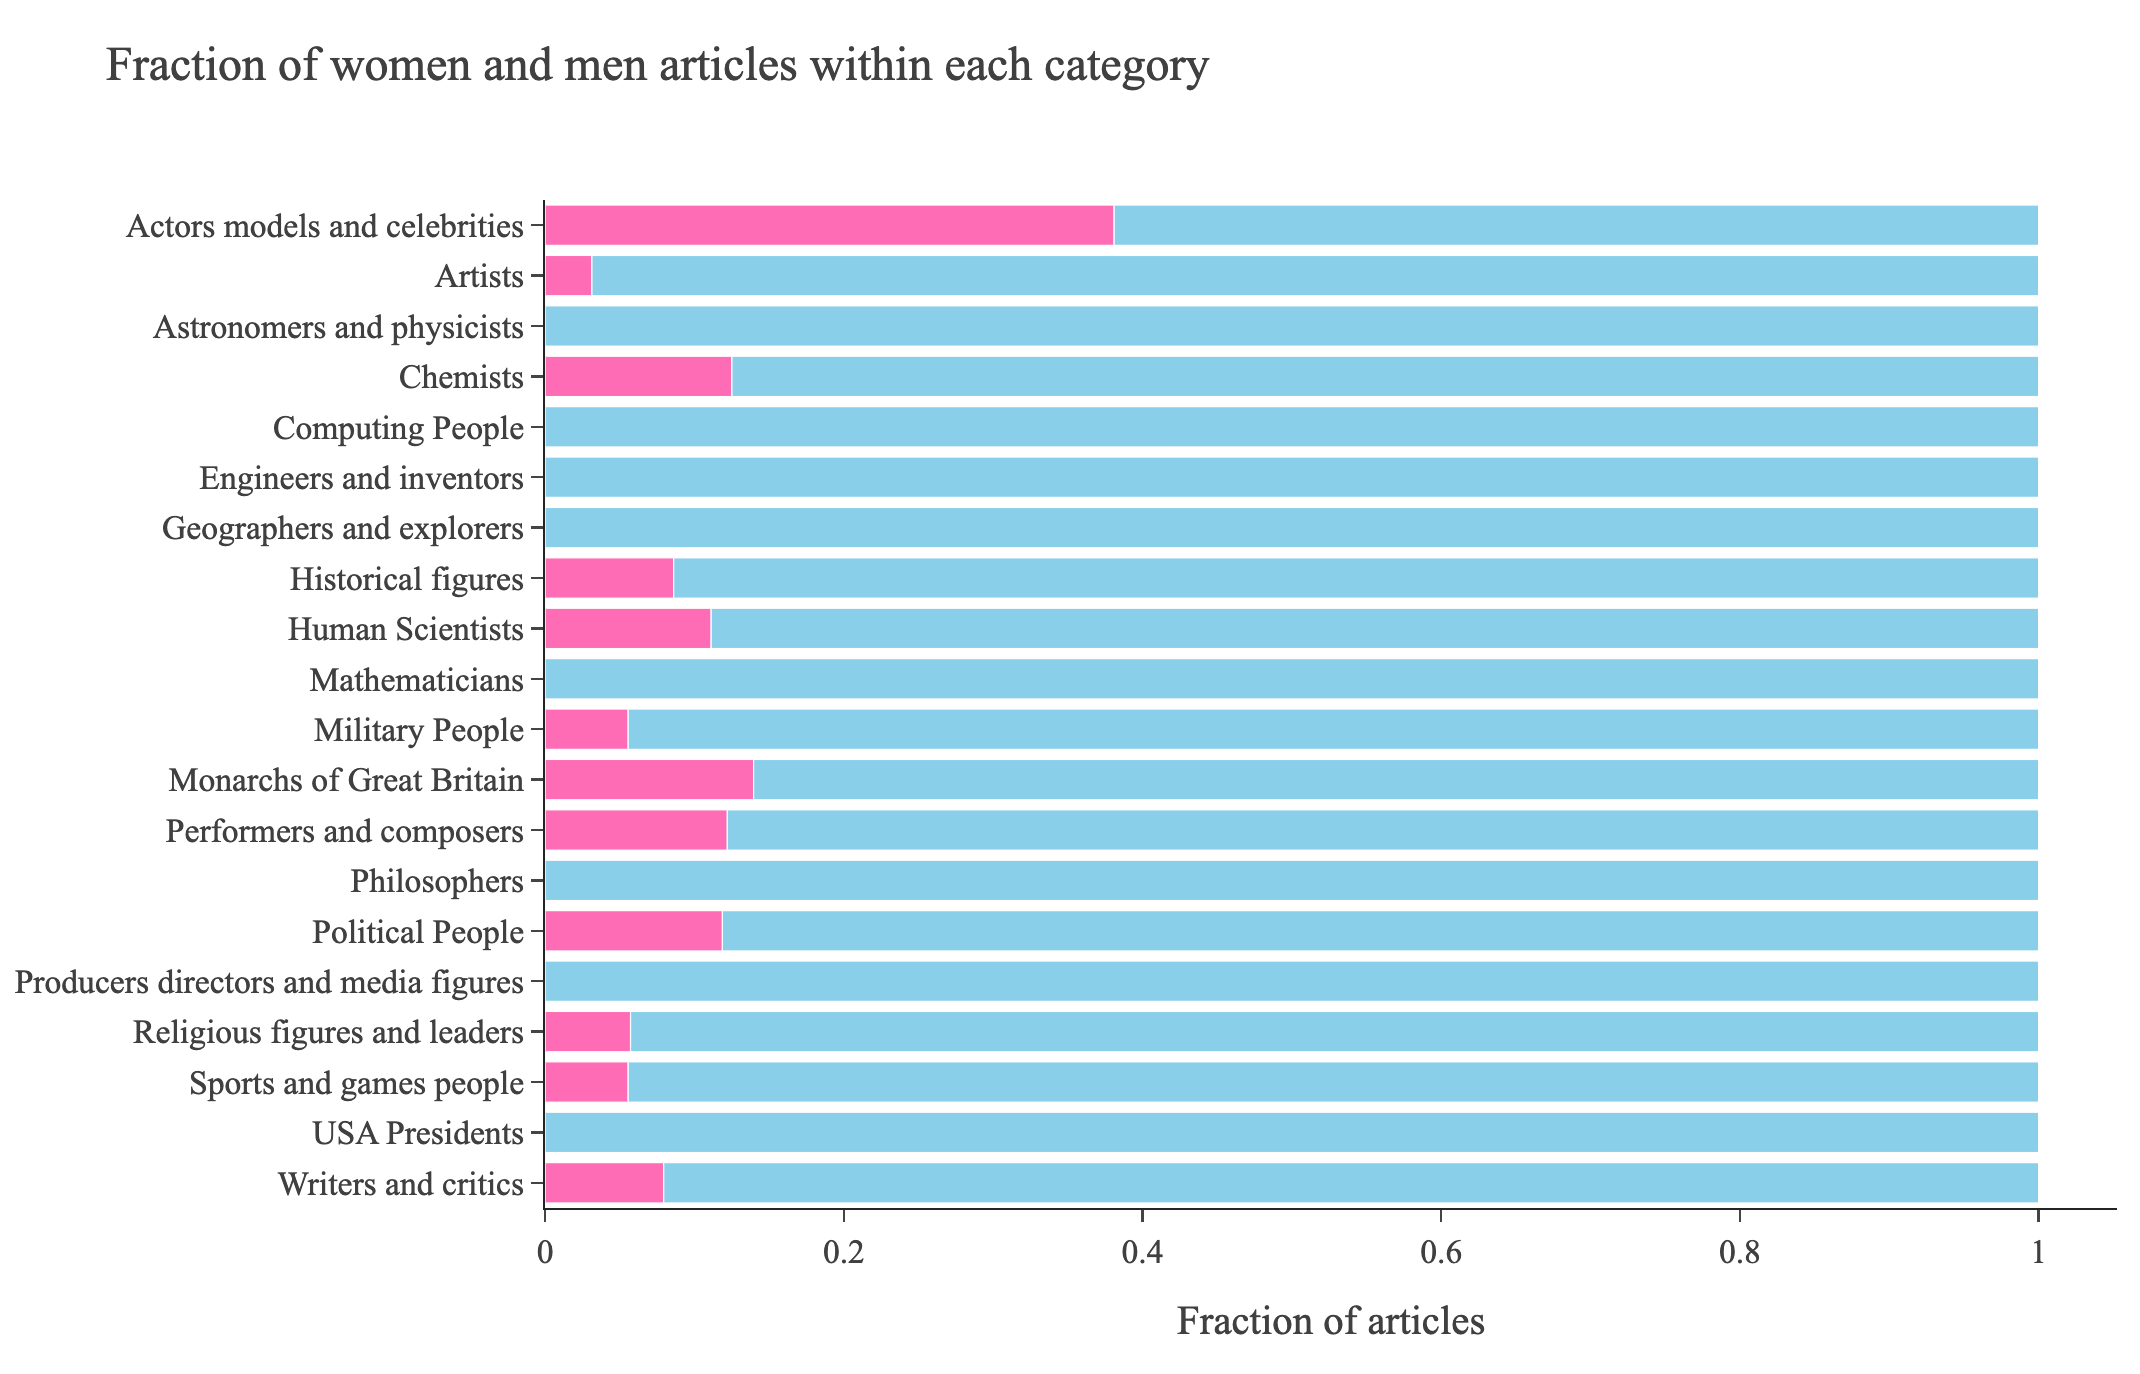

In [1642]:
Image(filename="images/plot2.png") #needed to display image

#### **Plot 3**

In [1643]:
categories = men_women_cat.index.str.replace('_', ' ')
men = men_women_cat['men'].values
women = men_women_cat['women'].values
women[np.isnan(women)] = 0
total = men + women

m = pd.DataFrame({'category': categories, 'amount': men,'gender': 'men'}).sort_values(by = ['category'])
w = pd.DataFrame({'category': categories, 'amount':women, 'gender':'women'}).sort_values(by = ['category'])
t = pd.concat([m, w])

fig = px.bar(t, y='category', x='amount', color='gender', barmode='group', 
             color_discrete_sequence = ['skyblue', 'hotpink'], 
             title = 'Number of women and men articles within each category',
             labels={"y": "Categories",
                    "amount": "Number of articles",
                    "gender": "Gender"},
             orientation='h',
             width=1000, height=600,
             template = 'simple_white')

fig.update_layout(yaxis=dict(title = None, autorange="reversed"), 
                  font_color = '#404040', font_family='Times New Roman, serif', font_size = 14)
fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot3.html", full_html=False, include_plotlyjs='cdn')

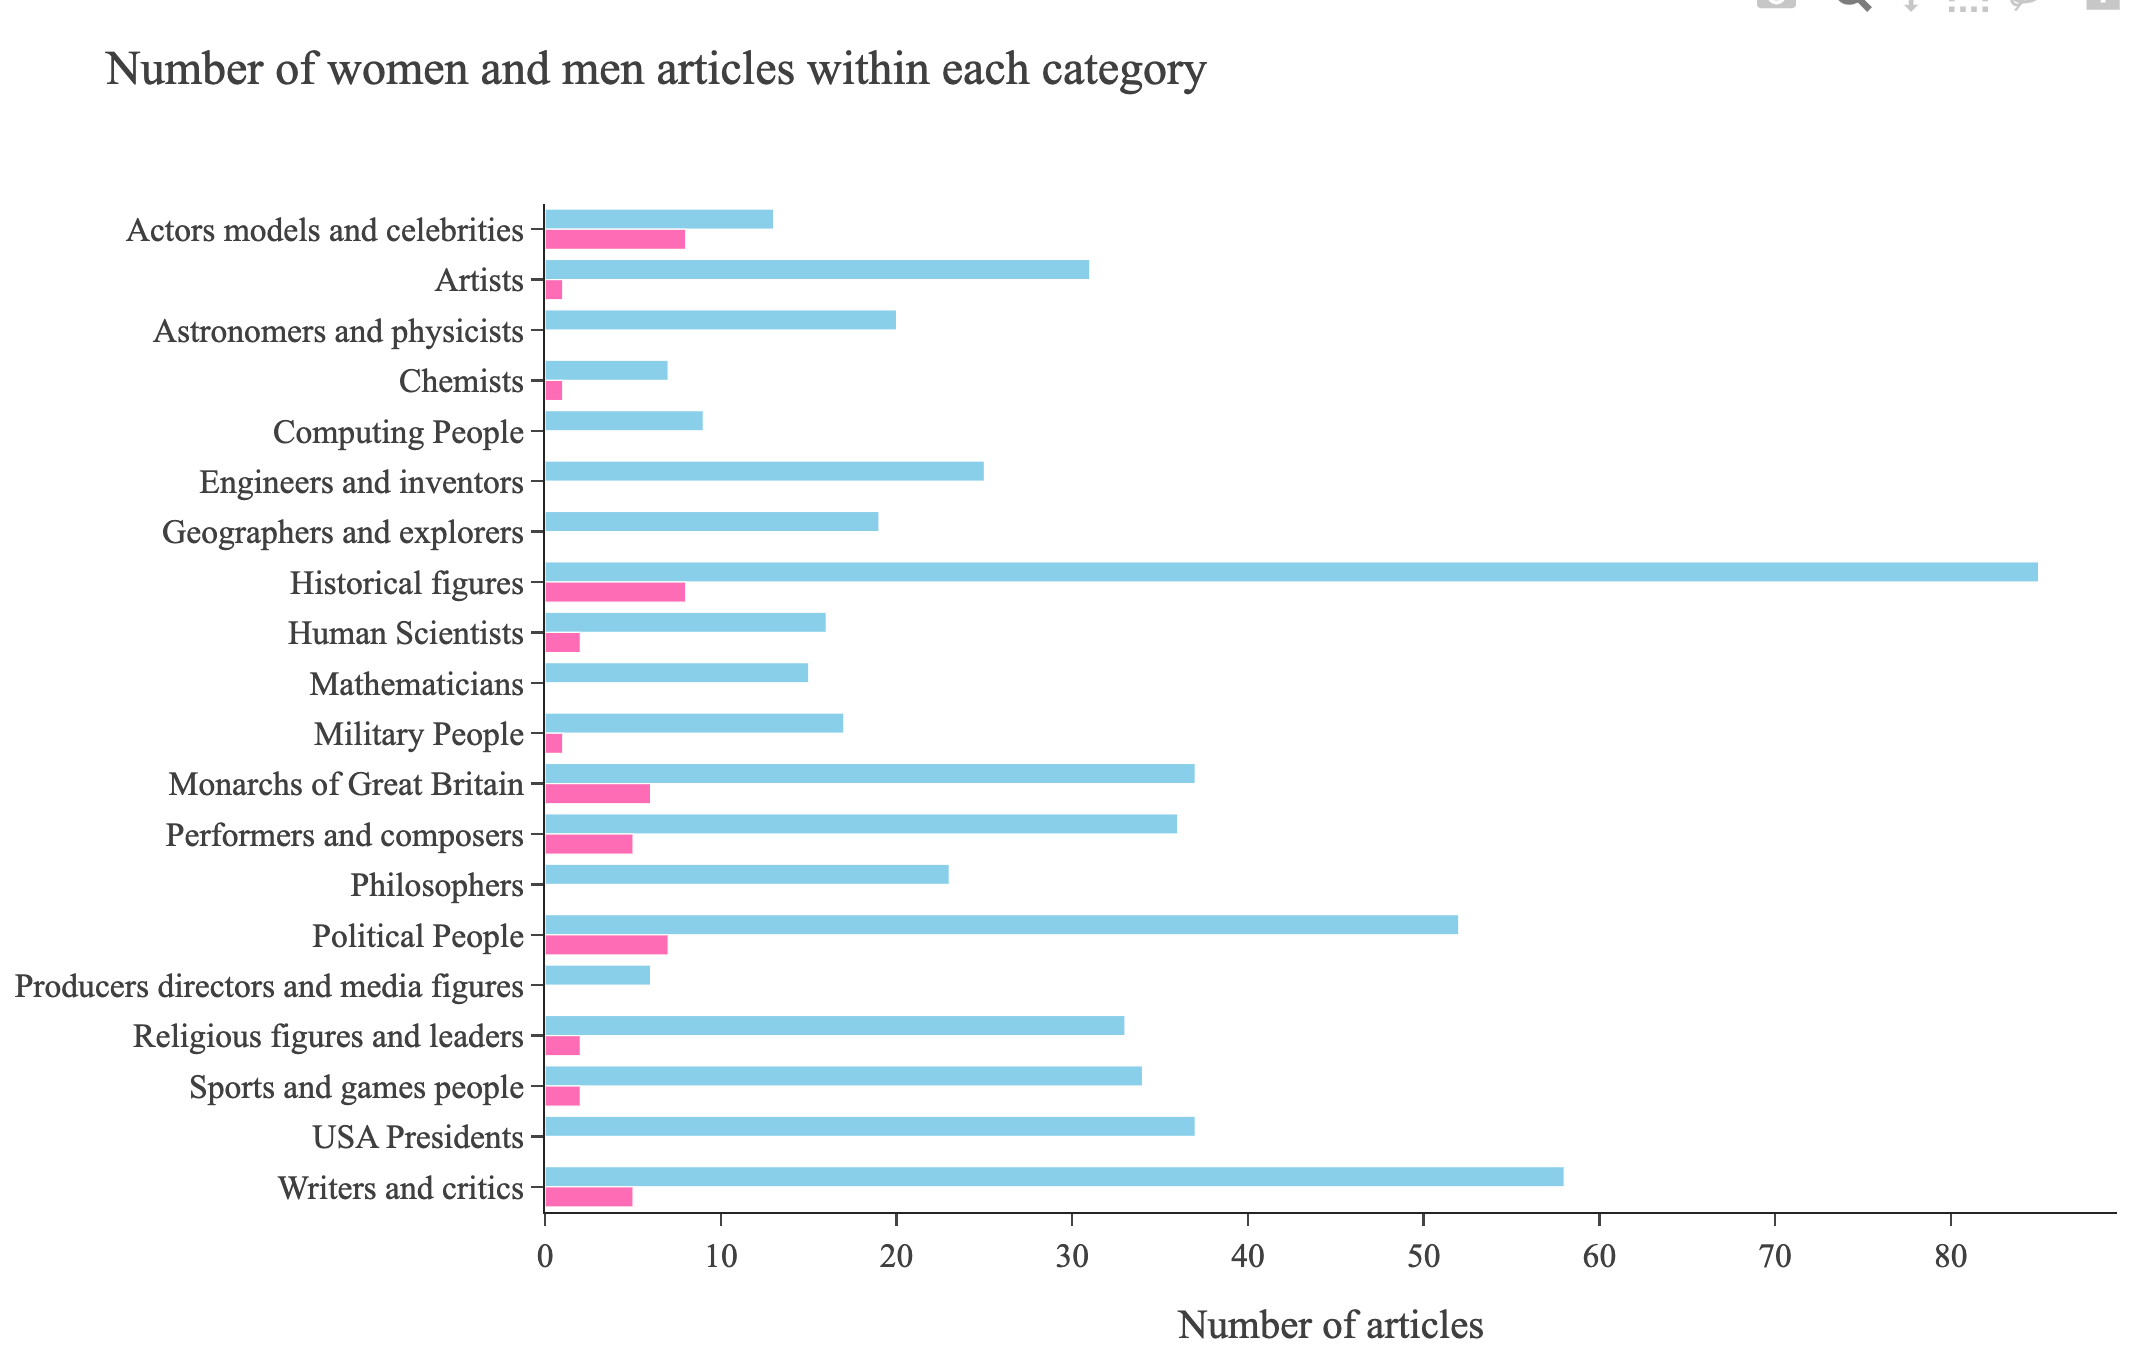

In [1644]:
Image(filename="images/plot3.png") #needed to display image

#### **Plot 4**

In [1645]:
men_target_paths = people_target_paths[people_target_paths['gender'] == 'male'].groupby('finished').count()
women_target_paths = people_target_paths[people_target_paths['gender'] == 'female'].groupby('finished').count()

labels = ["Unfinished paths", "Finished paths"]

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Women', 'Men'])

fig.add_trace(go.Pie(labels=labels, values=women_target_paths['source'], scalegroup='one',
                     name="Woman as target", marker=dict(colors=['#f7cac9', '#f7786b']), legendgroup = '1',
                    textfont_color='black'), 1, 1)

fig.add_trace(go.Pie(labels=labels, values=men_target_paths['source'], scalegroup='one',
                     name="Man as target", marker=dict(colors=['#92a8d1', '#034f84']), legendgroup = '2',
                    textfont_color='white'), 1, 2)

fig.update_layout(title_text='Paths depending on gender of the target article',
                  font_color = '#404040', font_family='Times New Roman, serif', font_size = 14,
                  showlegend=True)
fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/piechart.html", full_html=False, include_plotlyjs='cdn')

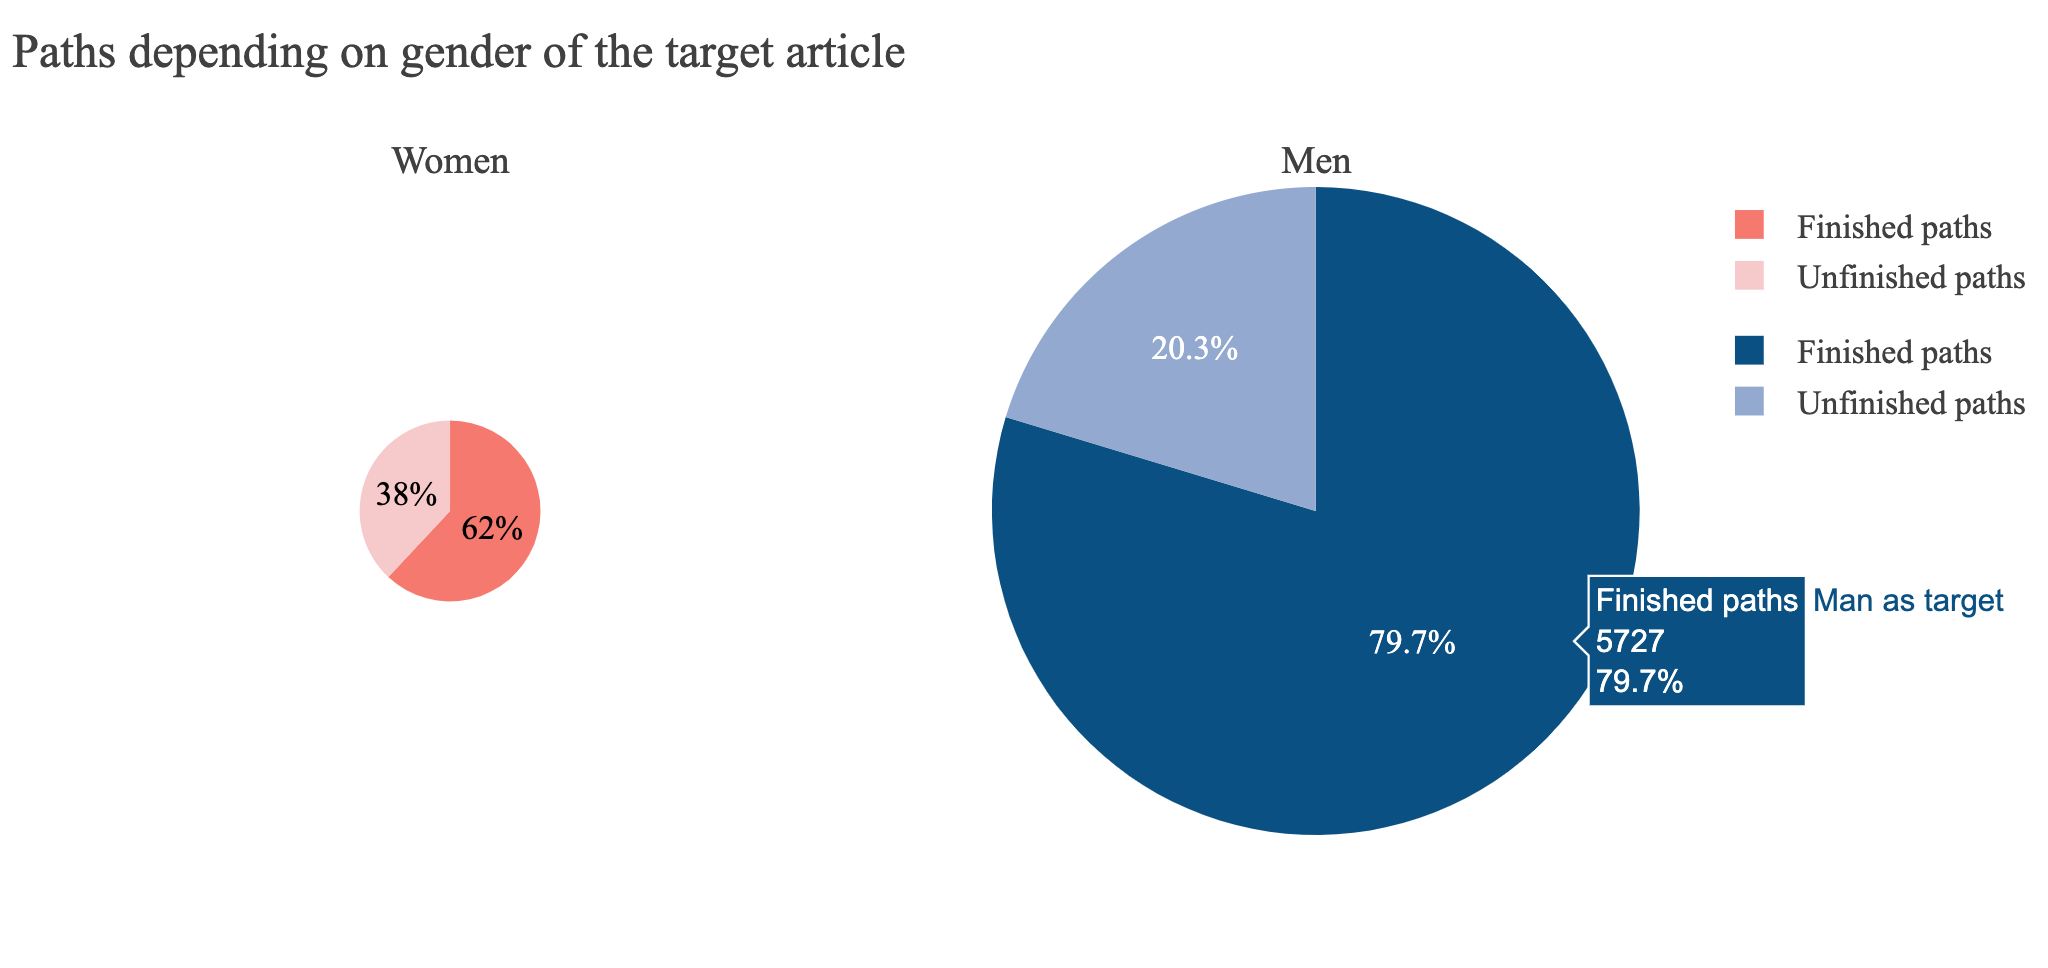

In [1646]:
Image(filename="images/plot4.png") #needed to display image

#### **Plot 5**

In [1647]:
import plotly
categories = ['Success rate','In-degree','Playtime [min]','Path deviation','Difficulty rating']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[wsuccessrate_mean, wlink_in, wplaytimemin_mean, wpathdev_mean, wdiffrating_mean],
      theta=categories,
      fill='toself',
      line_color='hotpink',
      name='Women'
))
fig.add_trace(go.Scatterpolar(
      r=[msuccessrate_mean, mlink_in, mplaytimemin_mean, mpathdev_mean, mdiffrating_mean],
      theta=categories,
      fill='toself',
      line_color='skyblue',
      name='Men'
))

fig.update_layout(
  polar=dict(radialaxis=dict(visible=True, range=[0, 10])), showlegend=True, 
    font_color = '#404040', font_family='Times New Roman, serif', font_size = 14)

fig.show()
# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/radarplot_naive.html", full_html=False, include_plotlyjs='cdn')

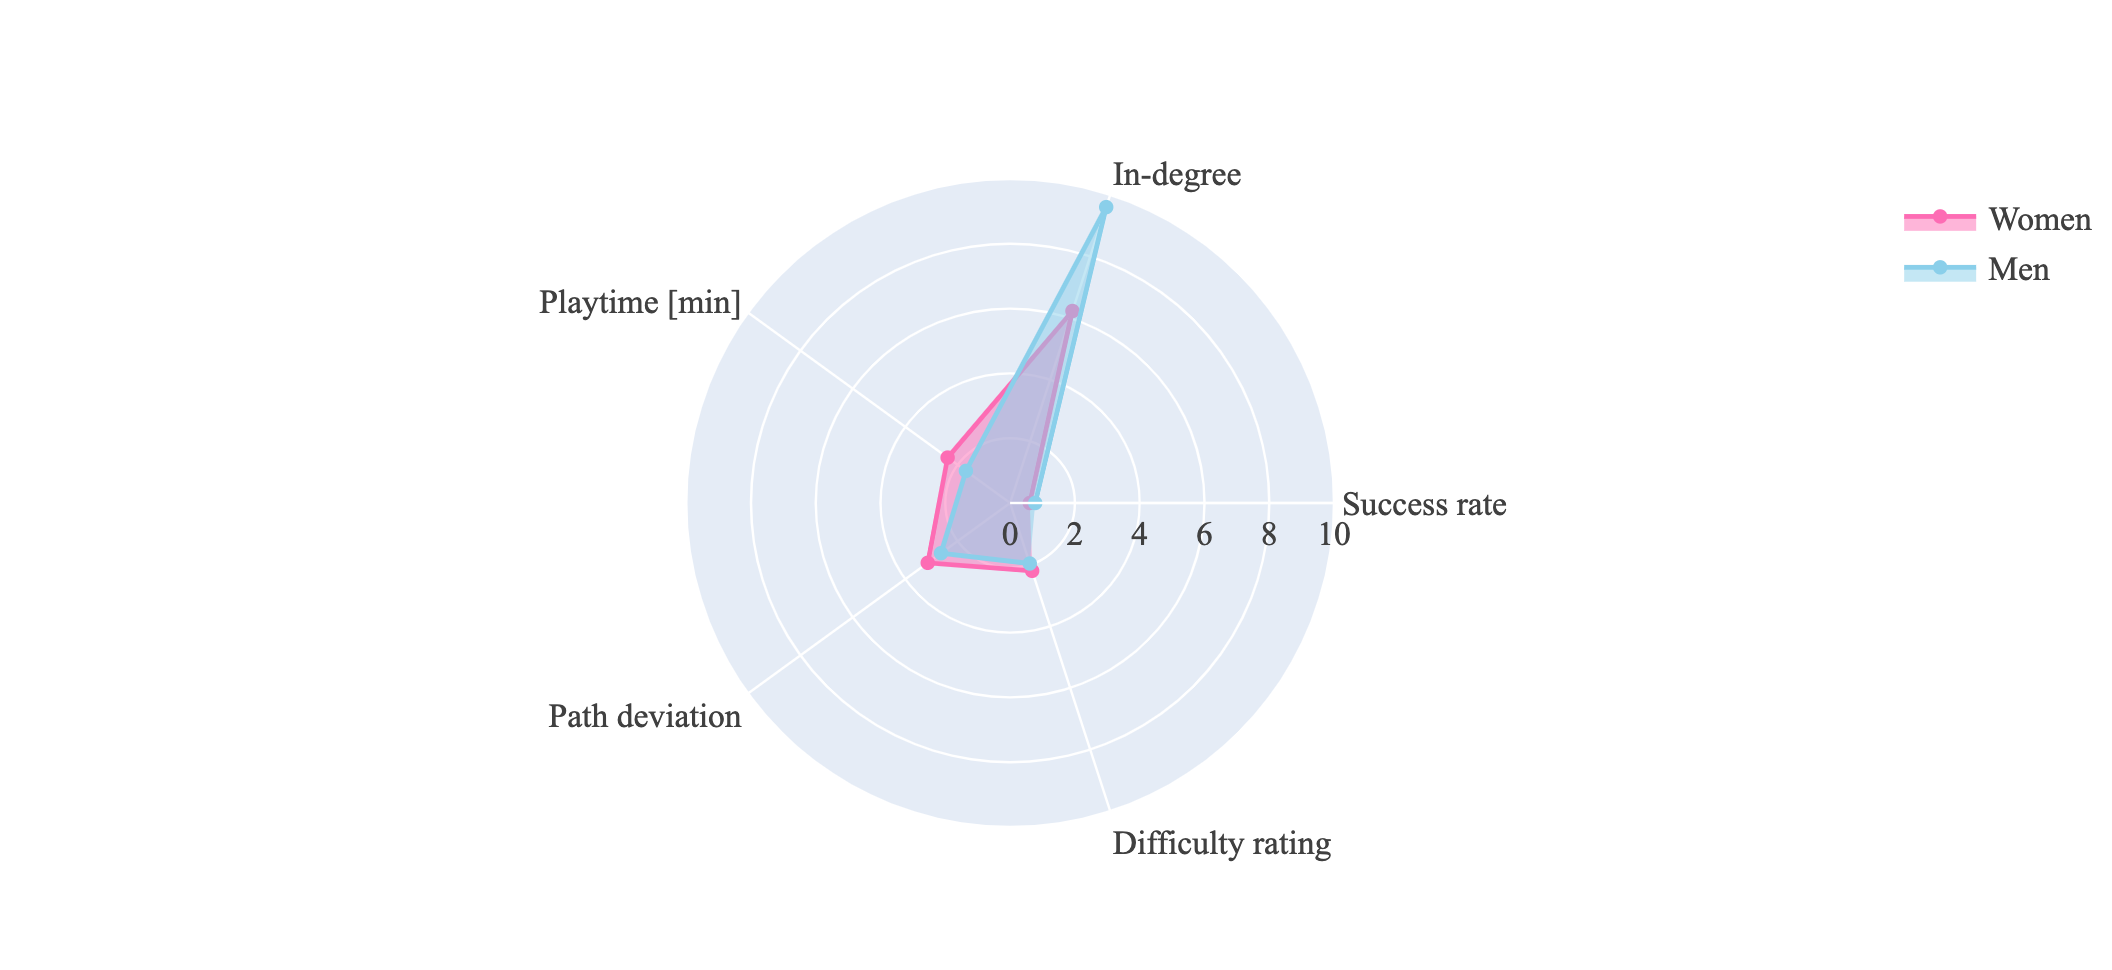

In [1648]:
Image(filename="images/plot5.png") #needed to display image